In [ ]:
# !sudo apt -y update
# !rm -f *.deb
# !sudo apt install -y wget curl unzip libvulkan1
# !wget http://archive.ubuntu.com/ubuntu/pool/main/libu/libu2f-host/libu2f-udev_1.1.4-1_all.deb
# !dpkg -i libu2f-udev_1.1.4-1_all.deb

# !wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
# !dpkg -i google-chrome-stable_current_amd64.deb

# !rm -rf /tmp/*
# !wget -N https://edgedl.me.gvt1.com/edgedl/chrome/chrome-for-testing/117.0.5938.88/linux64/chromedriver-linux64.zip -P /tmp/
# !unzip -o /tmp/chromedriver-linux64.zip -d /tmp/
# !cp -rf /tmp/chromedriver-linux64 /tmp/chromedriver
# !chmod +x /tmp/chromedriver/chromedriver
# !mv /tmp/chromedriver/chromedriver /usr/local/bin/chromedriver

# !pip install selenium==4.12.0

!pip install selenium==4.12.0

# install chromium-chromedriver (these commands are for ubuntu)

!apt-get update

!apt install chromium-chromedriver

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.2/400.2 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.1 MB/s eta 0:00:00
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [517 kB]
Get:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,264 kB]
Get:10 http://arc

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import TimeoutException
import csv
import pandas as pd
import time
import re

def initialize():
  options = webdriver.ChromeOptions()
  options.add_argument("--verbose")
  options.add_argument('--no-sandbox')
  options.add_argument('--headless')
  options.add_argument('--disable-gpu')
  options.add_argument("--window-size=1920, 1200")
  options.add_argument('--disable-dev-shm-usage')
  driver = webdriver.Chrome(
      options=options
  )
  return driver

#KAYAK

In [ ]:
def configure_kayak(driver):
  # Navigate to the Kayak website
  url = "https://www.kayak.com/flights/HEL-PMI/2023-10-28?sort=bestflight_a&fs=cfc=0;baditin=baditin;bfc=0"
  # Disable Bot
  driver.execute_cdp_cmd('Network.setUserAgentOverride', {"userAgent": 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.53 Safari/537.36'})
  driver.execute_script("Object.defineProperty(navigator, 'webdriver', {get: () => undefined})")
  driver.get(url)
  # Wait for the page to load (adjust the sleep time as needed)
  num_pages = 10
  for i in range(num_pages):
    WebDriverWait(driver, 100).until(EC.visibility_of_element_located((By.XPATH, '//div[text()="Show more results"]'))).click()

In [ ]:
def extract_kayak_data(driver):
  flight_list = []

  flight_card_list = WebDriverWait(driver, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "div[class='Fxw9']")))
  flight_cards = flight_card_list.find_elements(By.CSS_SELECTOR, "div[class='nrc6']")

  for flight_card in flight_cards:
    # Flight Name
    airline = flight_card.find_element(By.CSS_SELECTOR,"div[class='VY2U'] > div[class='c_cgF c_cgF-mod-variant-default']").text
    print("Airline= ",airline)

    # Flight Schedule
    for schedule_data in flight_card.find_elements(By.CSS_SELECTOR,"div[class='VY2U'] > div[class='vmXl vmXl-mod-variant-large']"):
      schedule = schedule_data.text
    departure = schedule.split("–")[0]
    arrival = schedule.split("–")[-1]
    print("Departure= ",departure)
    print("Arrival= ",arrival)

    # Flight Duration
    duration = flight_card.find_element(By.CSS_SELECTOR,"div[class='xdW8'] > div[class='vmXl vmXl-mod-variant-default']").text
    print("Duration = ", duration)

    # Flight Price
    price = flight_card.find_element(By.CSS_SELECTOR,'div[class="f8F1-price-text"]').text
    print("Price= ", price)

    # Flight Number of Transit
    stop = ', '.join([x.text for x in flight_card.find_elements(By.CLASS_NAME,"JWEO-stops-text")])
    print("No. Transit= ", stop)

    # Transit Time
    if 'nonstop' in stop:
      transit_time = '0h'
      transit_place_code = '-'
    else:
      WebDriverWait(flight_card, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, "div[class='nrc6-content-section']"))).click()
      try:
        WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "div[class='o-C7']")))
        WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.CLASS_NAME, "c62AT-duration")))
        transit_time = ', '.join([x.text for x in flight_card.find_elements(By.CLASS_NAME, "c62AT-duration")])

        # Flight Place Code to Transit
        transit_place_code = ', '.join([x.text[-4:-1] for x in flight_card.find_elements(By.CSS_SELECTOR,"div[class='c62AT-layover-info'] > span:last-child")])
        if (transit_place_code.isupper() == False and transit_place_code.count(', ') == 0) or (transit_place_code.count(', ') == 1):
          transit_place_code = ', '.join([x.text for x in flight_card.find_elements(By.CSS_SELECTOR,"div[class='JWEO'] > div[class='c_cgF c_cgF-mod-variant-default']")])
      except TimeoutException:
          transit_time = 'NAN'
      WebDriverWait(flight_card, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, "div[class='nrc6-content-section']"))).click()
    print("Layover Time= ", transit_time)
    print("Layover Place Code= ", transit_place_code)

	  # Flight Place to Transit
    if 'nonstop' in stop:
      transit_place = '-'
    else:
      transit_place = ', '.join([x.get_attribute('title').split('<b>')[1].split('</b>')[0] for x in flight_card.find_elements(By.CSS_SELECTOR,"div[class='JWEO'] > div[class='c_cgF c_cgF-mod-variant-default'] > span > span")])
    print("Layover Place= ", transit_place)

    info = {"Airline": airline, "Departure": departure, "Arrival": arrival, "Duration": duration, "Price": price, "No. Transit": stop,  "Layover Time": transit_time, "Layover Place Code": transit_place_code, "Layover Place": transit_place}
    flight_list.append(info)

    print()
  return flight_list

In [ ]:
driver = initialize()
configure_kayak(driver)
kayak_data = extract_kayak_data(driver)
kayak_data

Airline=  Norwegian
Departure=  6:00 am 
Arrival=   9:00 am
Duration =  4h 00m
Price=  $100
No. Transit=  nonstop
Layover Time=  0h
Layover Place Code=  -
Layover Place=  -

Airline=  Norwegian
Departure=  6:00 am 
Arrival=   9:00 am
Duration =  4h 00m
Price=  $94
No. Transit=  nonstop
Layover Time=  0h
Layover Place Code=  -
Layover Place=  -

Airline=  Ryanair
Departure=  11:20 pm 
Arrival=   10:50 pm
+1
Duration =  25h 30m
Price=  $65
No. Transit=  1 stop
Layover Time=  20h 35m
Layover Place Code=  WMI-WAW
Layover Place=  Airport change WMI-WAW

Airline=  Finnair
Departure=  7:45 am 
Arrival=   10:50 am
Duration =  4h 05m
Price=  $324
No. Transit=  nonstop
Layover Time=  0h
Layover Place Code=  -
Layover Place=  -

Airline=  Scandinavian Airlines
Departure=  7:00 am 
Arrival=   1:15 pm
Duration =  7h 15m
Price=  $114
No. Transit=  1 stop
Layover Time=  2h 35m
Layover Place Code=  CPH
Layover Place=  Kastrup Copenhagen

Airline=  Finnair, Ryanair
Departure=  5:05 pm 
Arrival=   10:35

[{'Airline': 'Norwegian',
  'Departure': '6:00 am ',
  'Arrival': ' 9:00 am',
  'Duration': '4h 00m',
  'Price': '$100',
  'No. Transit': 'nonstop',
  'Layover Time': '0h',
  'Layover Place Code': '-',
  'Layover Place': '-'},
 {'Airline': 'Norwegian',
  'Departure': '6:00 am ',
  'Arrival': ' 9:00 am',
  'Duration': '4h 00m',
  'Price': '$94',
  'No. Transit': 'nonstop',
  'Layover Time': '0h',
  'Layover Place Code': '-',
  'Layover Place': '-'},
 {'Airline': 'Ryanair',
  'Departure': '11:20 pm ',
  'Arrival': ' 10:50 pm\n+1',
  'Duration': '25h 30m',
  'Price': '$65',
  'No. Transit': '1 stop',
  'Layover Time': '20h 35m',
  'Layover Place Code': 'WMI-WAW',
  'Layover Place': 'Airport change WMI-WAW'},
 {'Airline': 'Finnair',
  'Departure': '7:45 am ',
  'Arrival': ' 10:50 am',
  'Duration': '4h 05m',
  'Price': '$324',
  'No. Transit': 'nonstop',
  'Layover Time': '0h',
  'Layover Place Code': '-',
  'Layover Place': '-'},
 {'Airline': 'Scandinavian Airlines',
  'Departure': '7:00 

In [ ]:
df_kayak = pd.DataFrame.from_dict(kayak_data)
df_kayak["website"] = "Kayak"
df_kayak

,Airline,Departure,Arrival,Duration,Price,No. Transit,Layover Time,Layover Place Code,Layover Place,website
0,Norwegian,6:00 am,9:00 am,4h 00m,$100,nonstop,0h,-,-,Kayak
1,Norwegian,6:00 am,9:00 am,4h 00m,$94,nonstop,0h,-,-,Kayak
2,Ryanair,11:20 pm,10:50 pm\n+1,25h 30m,$65,1 stop,20h 35m,WMI-WAW,Airport change WMI-WAW,Kayak
3,Finnair,7:45 am,10:50 am,4h 05m,$324,nonstop,0h,-,-,Kayak
4,Scandinavian Airlines,7:00 am,1:15 pm,7h 15m,$114,1 stop,2h 35m,CPH,Kastrup Copenhagen,Kayak
...,...,...,...,...,...,...,...,...,...,...
132,Lufthansa,6:10 pm,9:15 am\n+1,17h 05m,$359,1 stop,12h 20m,FRA,Frankfurt am Main,Kayak
133,Iberia,4:40 pm,8:35 am\n+1,17h 55m,$362,1 stop,12h 05m,MAD,Madrid Barajas,Kayak
134,Ryanair,10:50 pm,9:15 pm\n+1,24h 25m,$88,1 stop,19h 00m,STN,London Stansted,Kayak
135,Brussels Airlines,6:40 am,5:10 pm,11h 30m,$529,2 stops,"0h 45m, 4h 50m","FRA, BRU","Frankfurt am Main, Brussels Bruxelles-National",Kayak


In [ ]:
df_kayak.to_csv("kayak-10.csv", index = None)

#MOMONDO

In [ ]:
def configure_momondo(driver):
  url = "https://www.momondo.com/flight-search/HEL-PMI/2023-10-28?sort=bestflight_a"
  # Disable Bot
  driver.execute_cdp_cmd('Network.setUserAgentOverride', {"userAgent": 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.53 Safari/537.36'})
  driver.execute_script("Object.defineProperty(navigator, 'webdriver', {get: () => undefined})")
  driver.get(url)
  # Wait for the page to load (adjust the sleep time as needed)
  num_pages = 10
  for i in range(num_pages):
    WebDriverWait(driver, 100).until(EC.visibility_of_element_located((By.XPATH, '//div[text()="Show more results"]'))).click()

In [ ]:
def extract_momondo_data(driver):
  flight_list = []

  flight_card_list = WebDriverWait(driver, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "div[class='Fxw9']")))
  flight_cards = flight_card_list.find_elements(By.CSS_SELECTOR, "div[class='nrc6']")

  for flight_card in flight_cards:
    # Flight Name
    for airline_data in flight_card.find_elements(By.CSS_SELECTOR,"div[class='VY2U'] > div[class='c_cgF c_cgF-mod-variant-default']"):
      airline = airline_data.text

    # Flight Schedule
    for schedule_data in flight_card.find_elements(By.CSS_SELECTOR,"div[class='VY2U'] > div[class='vmXl vmXl-mod-variant-large']"):
      schedule = schedule_data.text
    departure = schedule.split("–")[0]
    arrival = schedule.split("–")[-1]

    # Flight Duration
    duration = flight_card.find_element(By.CSS_SELECTOR,"div[class='xdW8'] > div[class='vmXl vmXl-mod-variant-default']").text

    # Flight Price
    price = flight_card.find_element(By.CSS_SELECTOR,'div[class="f8F1-price-text"]').text

    # Flight Number of Transit
    stop = ', '.join([x.text for x in flight_card.find_elements(By.CLASS_NAME,"JWEO-stops-text")])

    # Transit Time
    if 'nonstop' in stop:
      transit_time = '0h'
      transit_place_code = '-'
    else:
      WebDriverWait(flight_card, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, "div[class='nrc6-content-section']"))).click()
      try:
        WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "div[class='o-C7']")))
        WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.CLASS_NAME, "c62AT-duration")))
        transit_time = ', '.join([x.text for x in flight_card.find_elements(By.CLASS_NAME, "c62AT-duration")])

        # Flight Place Code to Transit
        transit_place_code = ', '.join([x.text[-4:-1] for x in flight_card.find_elements(By.CSS_SELECTOR,"div[class='c62AT-layover-info'] > span:last-child")])
        if (transit_place_code.isupper() == False and transit_place_code.count(', ') == 0) or (transit_place_code.count(', ') == 1):
          transit_place_code = ', '.join([x.text for x in flight_card.find_elements(By.CSS_SELECTOR,"div[class='JWEO'] > div[class='c_cgF c_cgF-mod-variant-default']")])
      except TimeoutException:
          transit_time = 'NAN'
      WebDriverWait(flight_card, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, "div[class='nrc6-content-section']"))).click()

    # Flight Place to Transit
    if 'nonstop' in stop:
      transit_place = '-'
    else:
      transit_place = ', '.join([x.get_attribute('title').split('<b>')[1].split('</b>')[0] for x in flight_card.find_elements(By.CSS_SELECTOR,"div[class='JWEO'] > div[class='c_cgF c_cgF-mod-variant-default'] > span > span")])

    info = {"Airline": airline, "Departure": departure, "Arrival": arrival, "Duration": duration, "Price": price, "No. Transit": stop,  "Layover Time": transit_time, "Layover Place Code": transit_place_code, "Layover Place": transit_place}
    flight_list.append(info)

  return flight_list

In [ ]:
driver = initialize()
configure_momondo(driver)
momondo_data = extract_momondo_data(driver)
momondo_data

[{'Airline': 'Norwegian',
  'Departure': '6:00 am ',
  'Arrival': ' 9:00 am',
  'Duration': '4h 00m',
  'Price': '$101',
  'No. Transit': 'nonstop',
  'Layover Time': '0h',
  'Layover Place Code': '-',
  'Layover Place': '-'},
 {'Airline': 'Norwegian',
  'Departure': '6:00 am ',
  'Arrival': ' 9:00 am',
  'Duration': '4h 00m',
  'Price': '$94',
  'No. Transit': 'nonstop',
  'Layover Time': '0h',
  'Layover Place Code': '-',
  'Layover Place': '-'},
 {'Airline': 'Ryanair',
  'Departure': '11:20 pm ',
  'Arrival': ' 10:50 pm\n+1',
  'Duration': '25h 30m',
  'Price': '$65',
  'No. Transit': '1 stop',
  'Layover Time': '20h 35m',
  'Layover Place Code': 'WMI',
  'Layover Place': 'Airport change WMI-WAW'},
 {'Airline': 'Finnair',
  'Departure': '7:45 am ',
  'Arrival': ' 10:50 am',
  'Duration': '4h 05m',
  'Price': '$336',
  'No. Transit': 'nonstop',
  'Layover Time': '0h',
  'Layover Place Code': '-',
  'Layover Place': '-'},
 {'Airline': 'Scandinavian Airlines',
  'Departure': '7:00 am '

In [ ]:
df_momondo = pd.DataFrame.from_dict(momondo_data)
df_momondo["website"] = "Momondo"
df_momondo

,Airline,Departure,Arrival,Duration,Price,No. Transit,Layover Time,Layover Place Code,Layover Place,website
0,Norwegian,6:00 am,9:00 am,4h 00m,$101,nonstop,0h,-,-,Momondo
1,Norwegian,6:00 am,9:00 am,4h 00m,$94,nonstop,0h,-,-,Momondo
2,Ryanair,11:20 pm,10:50 pm\n+1,25h 30m,$65,1 stop,20h 35m,WMI,Airport change WMI-WAW,Momondo
3,Finnair,7:45 am,10:50 am,4h 05m,$336,nonstop,0h,-,-,Momondo
4,Scandinavian Airlines,7:00 am,1:15 pm,7h 15m,$114,1 stop,2h 35m,CPH,Kastrup Copenhagen,Momondo
...,...,...,...,...,...,...,...,...,...,...
146,Brussels Airlines,6:40 am,5:10 pm,11h 30m,$718,2 stops,"4h 45m, 1h 05m","FRA, BRU","Frankfurt am Main, Brussels Bruxelles-National",Momondo
147,Scandinavian Airlines,7:00 am,8:40 pm,14h 40m,$684,2 stops,"6h 35m, 2h 20m","CPH, GOT","Kastrup Copenhagen, Gothenburg Landvetter",Momondo
148,Scandinavian Airlines,7:00 am,8:40 pm,14h 40m,$684,2 stops,"0h 40m, 8h 20m","CPH, GOT","Kastrup Copenhagen, Gothenburg Landvetter",Momondo
149,Scandinavian Airlines,7:00 am,7:25 pm,13h 25m,$740,2 stops,"4h 05m, 2h 55m","CPH, OSL","Kastrup Copenhagen, Oslo Gardermoen",Momondo


In [ ]:
df_momondo.to_csv("momondo-10.csv", index = None)

#Booking

In [ ]:
def configure_booking(driver, page):
  url = f"https://flights.booking.com/flights/HEL.AIRPORT-PMI.AIRPORT?type=ONEWAY&adults=1&cabinClass=ECONOMY&children=&from=HEL.AIRPORT&to=PMI.AIRPORT&fromCountry=FI&toCountry=ES&fromLocationName=Helsinki-Vantaa+Airport&toLocationName=Palma+de+Mallorca+Airport&depart=2023-10-28&sort=BEST&travelPurpose=leisure&aid=304142&label=gen173nr-1FCAEoggI46AdIM1gEaEiIAQGYAQm4AQfIAQzYAQHoAQH4AQyIAgGoAgO4AtP32qgGwAIB0gIkYWRkZWU4OWYtYjMwNy00ZTc0LTk1NGUtOTIwY2QyYzQ1ZmUy2AIG4AIB&page={page}"
  # Disable Bot
  driver.execute_cdp_cmd('Network.setUserAgentOverride', {"userAgent": 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.53 Safari/537.36'})
  driver.execute_script("Object.defineProperty(navigator, 'webdriver', {get: () => undefined})")
  driver.get(url)
  # Wait for the page to load (adjust the sleep time as needed)
  return driver

In [ ]:
def extract_booking_data(driver):
  flight_list = []

  driver = configure_booking(driver, 1)

  # pages
  ol_pages = WebDriverWait(driver, 20).until(EC.visibility_of_element_located((By.XPATH, "//ol[contains(@class, 'Pagination-module__list')]")))
  # still can't get a consistent max number even after using last-child nor aria-label, sometimes its lower
  last_page = WebDriverWait(ol_pages, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "li:last-child > button"))).text.strip()
  # last_page = WebDriverWait(ol_pages, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "li:last-child > button"))).get_attribute('aria-label').strip()
  total_pages = int(last_page)
  print(f"Total pages: {total_pages}")

  for current_page in range(1, total_pages+1):
    driver = configure_booking(driver, current_page)
    # cards
    flight_cards_root = WebDriverWait(driver, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "div[data-testid='searchresults_list']")))
    flight_cards = flight_cards_root.find_elements(By.CSS_SELECTOR, "div[data-testid='searchresults_card']")

    for count, flight_card in enumerate(flight_cards):
      # Flight Name
      airline = flight_card.find_element(By.CSS_SELECTOR,"div[data-testid='flight_card_carrier_0']").text
      print("Airline= ",airline)

      # Flight Schedule
      departure = flight_card.find_element(By.CSS_SELECTOR,"div[data-testid='flight_card_segment_departure_time_0']").text
      arrival = flight_card.find_element(By.CSS_SELECTOR,"div[data-testid='flight_card_segment_destination_time_0']").text
      print("Departure= ",departure)
      print("Arrival= ",arrival)

      # Flight Duration
      duration = flight_card.find_element(By.CSS_SELECTOR,"div[data-testid='flight_card_segment_duration_0']").text
      print("Duration = ", duration)

      # Flight Price
      price = flight_card.find_element(By.CSS_SELECTOR,'div[class="css-vxcmzt"]').text
      print("Price= ", price)

      # Flight Number of Transit
      stop = flight_card.find_element(By.CSS_SELECTOR,"div[data-testid='flight_card_segment_stops_0']").text
      print("No. Transit= ", stop)

      # Transit Time
      if 'Direct' in stop:
        transit_time = '0h'
        transit_place_code = '-'
        transit_place = '-'
      else:
        flight_card.find_element(By.CSS_SELECTOR,"button[data-testid='flight_card_bound_select_flight']").click()
        WebDriverWait(driver, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "div[data-testid='flightdetails_sheet']")))
        flight_card_popup = driver.find_element(By.CSS_SELECTOR, "div[data-testid='flightdetails_sheet']")
        layover_pattern = r'Layover (\d+h \d+m)'
        transit_time = re.findall(layover_pattern, flight_card_popup.text)
        WebDriverWait(driver, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR,"button[aria-label='Close']"))).click()
      print("Layover Time= ", transit_time)

      info = {"Airline": airline, "Departure": departure, "Arrival": arrival, "Duration": duration, "Price": price, "No. Transit": stop,  "Layover Time": transit_time,
              }
      flight_list.append(info)

      print()
  return flight_list

In [ ]:
driver = initialize()
driver.save_screenshot('file_name.png')
booking_data = extract_booking_data(driver)
booking_data

Total pages: 25
Airline=  Norwegian Air International Ltd
Departure=  06:00
Arrival=  09:00
Duration =  4h 00m
Price=  $110.28
No. Transit=  Direct
Layover Time=  0h

Airline=  SAS, operated by Jettime A/S
Departure=  07:00
Arrival=  13:15
Duration =  7h 15m
Price=  $126.19
No. Transit=  1 stop
Layover Time=  ['2h 35m']

Airline=  Ryanair
Departure=  23:20
Arrival=  22:50
Duration =  25h 30m
Price=  $74.23
No. Transit=  1 stop
Layover Time=  ['2h 35m']

Airline=  Finnair
Departure=  17:05
Arrival=  22:00
Duration =  5h 55m
Price=  $230.17
No. Transit=  1 stop
Layover Time=  ['1h 00m']

Airline=  Finnair
Departure=  17:05
Arrival=  22:35
Duration =  6h 30m
Price=  $230.17
No. Transit=  1 stop
Layover Time=  ['1h 35m']

Airline=  Air Baltic
Departure=  05:25
Arrival=  16:25
Duration =  12h 00m
Price=  $138.35
No. Transit=  2 stops
Layover Time=  ['4h 50m']

Airline=  Ryanair
Departure=  21:05
Arrival=  19:10
Duration =  23h 05m
Price=  $94.72
No. Transit=  1 stop
Layover Time=  ['18h 15m

[{'Airline': 'Norwegian Air International Ltd',
  'Departure': '06:00',
  'Arrival': '09:00',
  'Duration': '4h 00m',
  'Price': '$110.28',
  'No. Transit': 'Direct',
  'Layover Time': '0h'},
 {'Airline': 'SAS, operated by Jettime A/S',
  'Departure': '07:00',
  'Arrival': '13:15',
  'Duration': '7h 15m',
  'Price': '$126.19',
  'No. Transit': '1 stop',
  'Layover Time': ['2h 35m']},
 {'Airline': 'Ryanair',
  'Departure': '23:20',
  'Arrival': '22:50',
  'Duration': '25h 30m',
  'Price': '$74.23',
  'No. Transit': '1 stop',
  'Layover Time': ['2h 35m']},
 {'Airline': 'Finnair',
  'Departure': '17:05',
  'Arrival': '22:00',
  'Duration': '5h 55m',
  'Price': '$230.17',
  'No. Transit': '1 stop',
  'Layover Time': ['1h 00m']},
 {'Airline': 'Finnair',
  'Departure': '17:05',
  'Arrival': '22:35',
  'Duration': '6h 30m',
  'Price': '$230.17',
  'No. Transit': '1 stop',
  'Layover Time': ['1h 35m']},
 {'Airline': 'Air Baltic',
  'Departure': '05:25',
  'Arrival': '16:25',
  'Duration': '12h

In [ ]:
df_booking = pd.DataFrame.from_dict(booking_data)
df_booking["Website"] = "Booking"
df_booking

,Airline,Departure,Arrival,Duration,Price,No. Transit,Layover Time,Website
0,Norwegian Air International Ltd,06:00,09:00,4h 00m,$110.28,Direct,0h,Booking
1,"SAS, operated by Jettime A/S",07:00,13:15,7h 15m,$126.19,1 stop,[2h 35m],Booking
2,Ryanair,23:20,22:50,25h 30m,$74.23,1 stop,[2h 35m],Booking
3,Finnair,17:05,22:00,5h 55m,$230.17,1 stop,[1h 00m],Booking
4,Finnair,17:05,22:35,6h 30m,$230.17,1 stop,[1h 35m],Booking
...,...,...,...,...,...,...,...,...
369,"Swiss, operated by Jettime A/S For Scandinavia...",07:00,18:55,12h 55m,"$2,635.68",2 stops,"[2h 05m, 5h 00m]",Booking
370,"Swiss, operated by Jettime A/S For Scandinavia...",07:00,19:20,13h 20m,"$2,635.68",2 stops,"[1h 55m, 6h 00m]",Booking
371,"Swiss, operated by Jettime A/S For Scandinavia...",07:00,19:20,13h 20m,"$2,635.68",2 stops,[7h 10m],Booking
372,"Swiss, operated by Xfly For Scandinavian Airlines",11:25,08:45,22h 20m,"$2,180.41",2 stops,"[1h 55m, 6h 00m]",Booking


In [ ]:
df_booking.to_csv("booking-4.csv", index = None)

#####DEPRECATED
#Google

In [ ]:
# def configure_google(driver):
#   # Navigate to the Google website
#   url = "https://www.google.com/travel/flights/search?tfs=CBwQAhooEgoyMDIzLTEwLTIwagwIAhIIL20vMGNfenhyDAgDEggvbS8wZzUyekABSAFwAYIBCwj___________8BmAEC&tfu=EgYIARABGAAqAggD"
#   # url = "https://www.google.com/travel/flights/search?tfs=CBwQAholEgoyMDIzLTEwLTI4KAFqBwgBEgNIRUxyDAgDEggvbS8wMTU2cUABSAFwAYIBCwj___________8BmAEC&tfu=EgYIAhABGAAqAggC"
#   # Disable Bot
#   driver.execute_cdp_cmd('Network.setUserAgentOverride', {"userAgent": 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.53 Safari/537.36'})
#   driver.execute_script("Object.defineProperty(navigator, 'webdriver', {get: () => undefined})")
#   driver.get(url)
#   WebDriverWait(driver, 100).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "div[jsname='YdtKid'] > ul[class='Rk10dc'] > li[class='ZVk93d']"))).click()

In [ ]:
# def extract_google_other_data(driver):
#   flight_list = []

#   flight_card_list = WebDriverWait(driver, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "div[jsname='YdtKid'] > ul[class='Rk10dc']")))
#   flight_cards = flight_card_list.find_elements(By.CSS_SELECTOR, "li[class='pIav2d']")

#   first_flight_discount = True

#   for flight_card in flight_cards:
#     # Flight Name
#     # for airline_data in flight_card.find_elements(By.CSS_SELECTOR,"div[class='Ir0Voe'] > div[class='sSHqwe tPgKwe ogfYpf']"):
#     # # for airline_data in flight_card.find_elements(By.CLASSNAME,"sSHqwe tPgKwe ogfYpf"):
#     #   airline = airline_data.text
#     airline = ""
#     print("Airline= ",airline)

#     # Flight Schedule
#     schedule_data = ''.join([x.text for x in flight_card.find_elements(By.CSS_SELECTOR,"div[class='Ir0Voe'] > div[class='zxVSec YMlIz tPgKwe ogfYpf']")])
#     schedule = schedule_data.replace("\n","")
#     # for schedule_data in flight_card.find_elements(By.CSS_SELECTOR,"div[class='Ir0Voe'] > div[class='zxVSec YMlIz tPgKwe ogfYpf']"):
#     #   schedule = schedule_data.text
#     departure = schedule.split("–")[0]
#     arrival = schedule.split("–")[-1]
#     print("Departure= ",departure)
#     print("Arrival= ",arrival)

#     # Flight Duration
#     duration = flight_card.find_element(By.CSS_SELECTOR,"div[class='Ak5kof'] > div[class='gvkrdb AdWm1c tPgKwe ogfYpf']").text
#     print("Duration = ", duration)

#     # Flight Price YMlIz FpEdX jLMuyc
#     # price = flight_card.find_element(By.CSS_SELECTOR,"div[class='YMlIz FpEdX']").text
#     # if first_flight_discount :
#     #   price = flight_card.find_element(By.CSS_SELECTOR,"div[class='YMlIz FpEdX jLMuyc']").text
#     #   first_flight_discount = False
#     # else:
#     #   price = flight_card.find_element(By.CSS_SELECTOR,"div[class='YMlIz FpEdX']").text
#     # price = flight_card.find_element(By.XPATH,"//div[contains(@class, 'YMlIz FpEdX')]").text
#     price = flight_card.find_element(By.CSS_SELECTOR,"div[class='BVAVmf I11szd POX3ye'] > div > span").text
#     print("Price= ", price)

#     # Flight Number of Transit
#     stop = flight_card.find_element(By.CSS_SELECTOR,"div[class='BbR8Ec'] > div[class='EfT7Ae AdWm1c tPgKwe']").text
#     print("Stop= ", stop)
#     # important_stop = ', '.join([x.text for x in flight_card.find_elements(By.CLASS_NAME,"BbR8Ec")])
#     # stop = important_stop.split("\n")[0]

#     # Flight Place to Transit
#     if 'nonstop' in stop:
#       transit_place_code = '-'
#     else:
#       transit_place_code = ', '.join([x.text for x in flight_card.find_elements(By.CSS_SELECTOR,"div[class='BbR8Ec'] > div[class='sSHqwe tPgKwe ogfYpf'] > span > span")])
#       print("Layover Place Code= ", transit_place_code)


#     # Transit Time
#     if 'nonstop' in stop:
#       transit_time = '0h'
#       transit_place = '-'
#     else:
#       # I am giveup to try to pull over the layover time especially when there is more than 1 stop
#       transit_time = 'NAN'
#       transit_place = 'NAN'
#       # WebDriverWait(flight_card, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, "div[jsname='UsVyAb']"))).click()
#       # try:
#       #   WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.CLASS_NAME, "m9ravf")))
#       #   transit_time = ', '.join([x.text for x in flight_card.find_elements(By.CLASS_NAME, "tvtJdb eoY5cb y52p7d")])

#       # #   # Flight Place Code to Transit
#       # #   transit_place_code = ', '.join([x.text[-4:-1] for x in flight_card.find_elements(By.CSS_SELECTOR,"div[class='c62AT-layover-info'] > span:last-child")])
#       # #   if (transit_place_code.isupper() == False and transit_place_code.count(', ') == 0) or (transit_place_code.count(', ') == 1):
#       # #     transit_place_code = ', '.join([x.text for x in flight_card.find_elements(By.CSS_SELECTOR,"div[class='JWEO'] > div[class='c_cgF c_cgF-mod-variant-default']")])
#       # except TimeoutException:
#       #     transit_time = 'NAN'
#       # # WebDriverWait(flight_card, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, "button[class='VfPpkd-LgbsSe VfPpkd-LgbsSe-OWXEXe-k8QpJ VfPpkd-LgbsSe-OWXEXe-Bz112c-M1Soyc VfPpkd-LgbsSe-OWXEXe-dgl2Hf nCP5yc AjY5Oe LQeN7 nJawce OTelKf XPGpHc mAozAc']"))).click()
#       # # transit_time = '0h'
#       # WebDriverWait(flight_card, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, "div[jsname='UsVyAb']"))).click()
#       # transit_place = '-'
#     print("Layover Time= ", transit_time)
#     print("Layover Place= ", transit_place)

#     info = {"Airline": airline, "Departure": departure, "Arrival": arrival, "Duration": duration, "Price": price, "No. Transit": stop,  "Layover Time": transit_time, "Layover Place Code": transit_place_code, "Layover Place": transit_place}
#     flight_list.append(info)

#     print()
#   return flight_list

In [ ]:
# driver = initialize()
# configure_google(driver)
# google_other_data = extract_google_other_data(driver)
# google_other_data

In [ ]:
# df_other_google = pd.DataFrame.from_dict(google_other_data)
# df_other_google["website"] = "Google Flight"
# df_other_google

In [ ]:
# df_other_google.to_csv("google-other.csv", index = None)

### The Problem for Google is even when you clicked the "show more" button, Some of the Document Object Model structure change.

#####DEPRECATED
#EXPEDIA

In [ ]:
# # Navigate to the Kayak website
# url = "https://www.expedia.fi/Flights-Search?flight-type=on&mode=search&trip=oneway&leg1=from:Helsinki,%20Suomi%20(HEL-Helsinki-Vantaa),to:Mallorca,%20Baleaarit,%20Espanja,departure:28.10.2023TANYT&options=cabinclass:economy&fromDate=28.10.2023&d1=2023-10-28&passengers=adults:1,infantinlap:N"
# # Disable Bot
# driver.execute_cdp_cmd('Network.setUserAgentOverride', {"userAgent": 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.53 Safari/537.36'})
# driver.execute_script("Object.defineProperty(navigator, 'webdriver', {get: () => undefined})")
# driver.get(url)

In [ ]:
# SCROLL_PAUSE_TIME = 5

# # Get scroll height
# last_height = driver.execute_script("return document.body.scrollHeight")

# while True:
#     # Scroll down to bottom
#     driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

#     # Wait to load page
#     time.sleep(SCROLL_PAUSE_TIME)

#     # Calculate new scroll height and compare with last scroll height
#     new_height = driver.execute_script("return document.body.scrollHeight")
#     if new_height == last_height:
#         break
#     last_height = new_height

In [ ]:
# flight_list = []

# flight_card_list = WebDriverWait(driver, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "ul[class='uitk-typelist uitk-typelist-orientation-stacked uitk-typelist-size-2 uitk-typelist-spacing']")))
# flight_cards = flight_card_list.find_elements(By.CSS_SELECTOR, "li[data-test-id='offer-listing']")

In [ ]:
# print(len(flight_cards))

In [ ]:
# WebDriverWait(driver, 100).until(EC.visibility_of_element_located((By.XPATH, '//button[text()="Näytä lisää"]'))).click()

In [ ]:
# flight_card_list = WebDriverWait(driver, 100).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "ul[class='uitk-typelist uitk-typelist-orientation-stacked uitk-typelist-size-2 uitk-typelist-spacing']")))
# flight_cards = flight_card_list.find_elements(By.CSS_SELECTOR, "li[data-test-id='offer-listing']")

In [ ]:
# print(len(flight_cards))

### The Problem for Expedia is even when you clicked the "show more" button, it didnt show anything else.

# Data Preprocessing

In [ ]:
# If you don't want to scrap the data, you can uncomment this part

import pandas as pd
import numpy as np
import seaborn as sns
import time
from datetime import datetime, timedelta
import re
import ast
import warnings
from google.colab import drive
# Suppress all warnings
warnings.filterwarnings('ignore')

drive.mount('/content/drive')
booking_raw_id = '13_UFvqL6bBJcRUcU6ActocluGKLwzffi'
kayak_raw_id = '1dLIJi2kxRkRhzoac00uQG5wZPLIvOzK5'
momondo_raw_id = '1OeSt3hjJEXDNr2rKsUXXJeyQRgwCn6nK'

booking_raw_csv = f'https://drive.google.com/uc?id={booking_raw_id}'
kayak_raw_csv = f'https://drive.google.com/uc?id={kayak_raw_id}'
momondo_raw_csv = f'https://drive.google.com/uc?id={momondo_raw_id}'

df_booking = pd.read_csv(booking_raw_csv)
df_kayak = pd.read_csv(kayak_raw_csv)
df_momondo = pd.read_csv(momondo_raw_csv)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_booking

,Airline,Departure,Arrival,Duration,Price,No. Transit,Layover Time,Layover Place Code,Layover Place,Website
0,Norwegian Air International Ltd,06:00,09:00,4h 00m,$110.54,Direct,0h,-,-,Booking
1,"SAS, operated by Jettime A/S",07:00,13:15,7h 15m,$130.88,1 stop,['2h 35m'],['CPH'],['Copenhagen Apt'],Booking
2,Ryanair,22:50,10:25,12h 35m,$119.24,1 stop,['7h 15m'],"['STN', 'LTN']","['London Stansted Apt', 'London Luton Apt']",Booking
3,Ryanair,23:20,22:50,25h 30m,$77.36,1 stop,['19h 35m'],NaN,NaN,Booking
4,Norwegian Air International Ltd,06:15,18:35,13h 20m,$127.70,1 stop,['2h 35m'],['CPH'],['Copenhagen Apt'],Booking
...,...,...,...,...,...,...,...,...,...,...
353,"Swiss, operated by Jettime A/S",07:00,19:20,13h 20m,"$2,627.35",2 stops,"['1h 55m', '6h 00m']","['CPH', 'ZRH']","['Copenhagen Apt', 'Zurich Airport']",Booking
354,"Swiss, operated by Jettime A/S",07:00,19:20,13h 20m,"$2,627.35",2 stops,['7h 10m'],"['CPH', 'ZRH']","['Copenhagen Apt', 'Zurich Airport']",Booking
355,"Swiss, operated by Xfly For Scandinavian Airlines",11:25,08:45,22h 20m,"$2,168.43",2 stops,"['1h 55m', '6h 00m']","['CPH', 'ZRH']","['Copenhagen Apt', 'Zurich Airport']",Booking
356,"Swiss, operated by Cityjet For Scandinavian Ai...",11:15,08:45,22h 30m,"$2,627.35",2 stops,['7h 10m'],"['CPH', 'ZRH']","['Copenhagen Apt', 'Zurich Airport']",Booking


In [ ]:
df_kayak

,Airline,Departure,Arrival,Duration,Price,No. Transit,Layover Time,Layover Place Code,Layover Place,website
0,Norwegian,6:00 am,9:00 am,4h 00m,$100,nonstop,0h,-,-,Kayak
1,Norwegian,6:00 am,9:00 am,4h 00m,$94,nonstop,0h,-,-,Kayak
2,Ryanair,11:20 pm,10:50 pm\n+1,25h 30m,$65,1 stop,20h 35m,WMI-WAW,Airport change WMI-WAW,Kayak
3,Finnair,7:45 am,10:50 am,4h 05m,$324,nonstop,0h,-,-,Kayak
4,Scandinavian Airlines,7:00 am,1:15 pm,7h 15m,$114,1 stop,2h 35m,CPH,Kastrup Copenhagen,Kayak
...,...,...,...,...,...,...,...,...,...,...
132,Lufthansa,6:10 pm,9:15 am\n+1,17h 05m,$359,1 stop,12h 20m,FRA,Frankfurt am Main,Kayak
133,Iberia,4:40 pm,8:35 am\n+1,17h 55m,$362,1 stop,12h 05m,MAD,Madrid Barajas,Kayak
134,Ryanair,10:50 pm,9:15 pm\n+1,24h 25m,$88,1 stop,19h 00m,STN,London Stansted,Kayak
135,Brussels Airlines,6:40 am,5:10 pm,11h 30m,$529,2 stops,"0h 45m, 4h 50m","FRA, BRU","Frankfurt am Main, Brussels Bruxelles-National",Kayak


In [ ]:
df_momondo

,Airline,Departure,Arrival,Duration,Price,No. Transit,Layover Time,Layover Place Code,Layover Place,website
0,Norwegian,6:00 am,9:00 am,4h 00m,$101,nonstop,0h,-,-,Momondo
1,Norwegian,6:00 am,9:00 am,4h 00m,$94,nonstop,0h,-,-,Momondo
2,Ryanair,11:20 pm,10:50 pm\n+1,25h 30m,$65,1 stop,20h 35m,WMI,Airport change WMI-WAW,Momondo
3,Finnair,7:45 am,10:50 am,4h 05m,$336,nonstop,0h,-,-,Momondo
4,Scandinavian Airlines,7:00 am,1:15 pm,7h 15m,$114,1 stop,2h 35m,CPH,Kastrup Copenhagen,Momondo
...,...,...,...,...,...,...,...,...,...,...
146,Brussels Airlines,6:40 am,5:10 pm,11h 30m,$718,2 stops,"4h 45m, 1h 05m","FRA, BRU","Frankfurt am Main, Brussels Bruxelles-National",Momondo
147,Scandinavian Airlines,7:00 am,8:40 pm,14h 40m,$684,2 stops,"6h 35m, 2h 20m","CPH, GOT","Kastrup Copenhagen, Gothenburg Landvetter",Momondo
148,Scandinavian Airlines,7:00 am,8:40 pm,14h 40m,$684,2 stops,"0h 40m, 8h 20m","CPH, GOT","Kastrup Copenhagen, Gothenburg Landvetter",Momondo
149,Scandinavian Airlines,7:00 am,7:25 pm,13h 25m,$740,2 stops,"4h 05m, 2h 55m","CPH, OSL","Kastrup Copenhagen, Oslo Gardermoen",Momondo


In [ ]:
def clean_data(df_booking, df_kayak, df_momondo):
  print("No of Booking Data before cleaning: ", len(df_booking))
  print("No of Kayak Data before cleaning: ", len(df_kayak))
  print("No of Momondo Data before cleaning: ", len(df_momondo))

  # Remove duplicates
  df_booking.drop_duplicates(inplace = True)
  df_kayak.drop_duplicates(inplace = True)
  df_momondo.drop_duplicates(inplace = True)

  print()

  # Remove NA value
  df_booking.dropna(inplace = True)
  df_kayak.dropna(inplace = True)
  df_momondo.dropna(inplace = True)

  # Remove NA value
  df_booking = df_booking[df_booking["Layover Time"] != "NAN"]
  df_kayak = df_kayak[df_kayak["Layover Time"] != "NAN"]
  df_momondo = df_momondo[df_momondo["Layover Time"] != "NAN"]

  print("No of Booking Data after cleaning: ", len(df_booking))
  print("No of Kayak Data after cleaning: ", len(df_kayak))
  print("No of Momondo Data after cleaning: ", len(df_momondo))

  return df_booking, df_kayak, df_momondo

In [ ]:
def clean_after_preprocess(df_booking, df_kayak, df_momondo):
  print("No of Booking Data before cleaning: ", len(df_booking))
  print("No of Kayak Data before cleaning: ", len(df_kayak))
  print("No of Momondo Data before cleaning: ", len(df_momondo))

  df_booking = df_booking[df_booking["Duration"] > df_booking["Layover Time"]]
  df_kayak = df_kayak[df_kayak["Duration"] > df_kayak["Layover Time"]]
  df_momondo = df_momondo[df_momondo["Duration"] > df_momondo["Layover Time"]]

  # Remove NA value
  df_booking = df_booking[df_booking["Layover Time"] != "NAN"]
  df_kayak = df_kayak[df_kayak["Layover Time"] != "NAN"]
  df_momondo = df_momondo[df_momondo["Layover Time"] != "NAN"]

  # Special Case for Booking
  df_booking = df_booking[df_booking["Check"] != "NaN"]

  print("No of Booking Data after cleaning: ", len(df_booking))
  print("No of Kayak Data after cleaning: ", len(df_kayak))
  print("No of Momondo Data after cleaning: ", len(df_momondo))

  return df_booking, df_kayak, df_momondo

## Preprocessing For Kayak and Momoda

In [ ]:
# For Kayak and Momondo
def remove_char_layover_code(df):
  # Define a regular expression pattern to match the characters to be removed
  pattern = r'[ \[\]\']'
  # Use the re.sub() function to remove the characters
  cleaned_string = re.sub(pattern, '', df["Layover Place Code"])
  return cleaned_string

def normalize_place_transit_kayak_momondo(df):
  df["LayoverPlaceCode"] = df.apply(lambda x: remove_char_layover_code(x), axis = 1)
  df.drop(["Layover Place Code"], axis = 1, inplace = True)
  df.rename(columns={"LayoverPlaceCode": "Layover Place Code"}, inplace = True)

def change_nonstop_direct(df):
  if df["No. Transit"] == "nonstop":
    return "Direct"
  else:
    return df["No. Transit"]

def normalize_no_transit_kayak_momondo(df):
  df["No.Transit"] = df.apply(lambda x: change_nonstop_direct(x), axis = 1)
  df.drop(["No. Transit"], axis = 1, inplace = True)
  df.rename(columns={"No.Transit": "No. Transit", "website": "Website"}, inplace = True)

def convert_duration(df):
  # Split the string into hours and minutes
  time_parts = df["Duration"].split()

  # Initialize a timedelta object with the hours and minutes
  time_duration = timedelta(hours=int(time_parts[0][:-1]), minutes=int(time_parts[1][:-1]))
  return time_duration

def normalize_duration(df):
  df["duration"] = df.apply(lambda x: convert_duration(x), axis = 1)
  df.drop(["Duration"], axis = 1, inplace = True)
  df.rename(columns={"duration": "Duration"}, inplace = True)

def convert_departure_datetime_am_pm(df):
  date_string = '2023-10-28'
  time_string = df["Departure"]
  time_string = re.sub(r'\s', '', time_string)

  # Combine date and time strings
  datetime_string = date_string + ' ' + time_string

  # Convert to datetime using pd.to_datetime
  datetime_12hr = datetime.strptime(datetime_string, '%Y-%m-%d %I:%M%p')
  datetime_24hr = datetime_12hr.strftime('%Y-%m-%d %H:%M:%S')
  return datetime_24hr

def convert_arrival_datetime_am_pm(df):
  date_string = '2023-10-28'
  time_string = df["Arrival"]
  time_string = re.sub(r'\s', '', time_string)
  # Check if the string contains "+1"
  if "+1" in time_string:
    date_string = '2023-10-29'
    time_string = re.sub(r'\+1', '', time_string)

  # Combine date and time strings
  datetime_string = date_string + ' ' + time_string

  # Convert to datetime using pd.to_datetime
  datetime_12hr = datetime.strptime(datetime_string, '%Y-%m-%d %I:%M%p')
  datetime_24hr = datetime_12hr.strftime('%Y-%m-%d %H:%M:%S')

  if datetime_24hr < df["Dep"]:
    # Add 1 day because Arrival > Departure
    date_string = '2023-10-29'
    datetime_string = date_string + ' ' + time_string
    # Combine date and time strings
    datetime_string = date_string + ' ' + time_string

    # Convert to datetime using pd.to_datetime
    datetime_12hr = datetime.strptime(datetime_string, '%Y-%m-%d %I:%M%p')
    datetime_24hr = datetime_12hr.strftime('%Y-%m-%d %H:%M:%S')

  return datetime_24hr

def normalize_datetime_kayak_momondo(df):
  df["Dep"] = df.apply(lambda x: convert_departure_datetime_am_pm(x), axis = 1)
  df["Arr"] = df.apply(lambda x: convert_arrival_datetime_am_pm(x), axis = 1)
  df.drop(["Departure", "Arrival"], axis = 1, inplace = True)
  df.rename(columns={"Dep": "Departure", "Arr": "Arrival"}, inplace = True)

def convert_price(df):
  price = df["Price"]
  price = re.sub(r'[ \t$]', '', price)
  return int(price)

def normalize_price_kayak_momondo(df):
  df["price"] = df.apply(lambda x: convert_price(x), axis = 1)
  df.drop(["Price"], axis = 1, inplace = True)
  df.rename(columns={"price": "Price"}, inplace = True)

def convert_layover(df):
  # Split the string into individual time components
  time_components = df["Layover Time"].split(', ')

  # Initialize variables to store total hours and total minutes
  total_hours = 0
  total_minutes = 0

  # Iterate through each time component and add to the totals
  for component in time_components:
      parts = component.split()
      if len(parts) == 1:
        if 'h' in parts[0]:
          parts.append("0m")
        elif 'm' in parts[0]:
          parts.append("0h")
      if 'h' in parts[0]:
          total_hours += int(parts[0].replace('h', ''))
      if 'm' in parts[1]:
          total_minutes += int(parts[1].replace('m', ''))

  # Create a timedelta object with the total hours and minutes
  total_time = timedelta(hours=total_hours, minutes=total_minutes)
  return total_time

def normalize_layover(df):
  df["Layover Time"] = df.apply(lambda x: convert_layover(x), axis = 1)
  # df.drop(["Layover Time"], axis = 1, inplace = True)
  # df.rename(columns={"LayoverTime": "Layover Time"}, inplace = True)

def rearrange_columns_kayak_momondo(df):
  cols = ['Airline', 'Departure', 'Arrival', 'No. Transit', 'Layover Place Code', 'Layover Place',  'Layover Time', 'Duration',  'Website', 'Price']
  df = df[cols]
  return df

def normalize_kayak_momondo(df):
  normalize_place_transit_kayak_momondo(df)
  normalize_no_transit_kayak_momondo(df)
  normalize_duration(df)
  normalize_datetime_kayak_momondo(df)
  normalize_price_kayak_momondo(df)
  normalize_layover(df)
  df = rearrange_columns_kayak_momondo(df)
  return df

## Preprocessing For Booking

In [ ]:
def remove_buggy_data(df):
  if df["No. Transit"] == "2 stops":
    elements_list = ast.literal_eval(df["Layover Place Code"])
    # Check if it's a list and has exactly 2 elements
    if isinstance(elements_list, list) and len(elements_list) == 2:
        return "OK"
    else:
        return "NaN"
  else:
    return "OK"

def normalize_transit_place_booking(df):
  df["Check"] = df.apply(lambda x: remove_buggy_data(x), axis = 1)

def remove_char_layover_time(df):
  # Define a regular expression pattern to match the characters to be removed
  pattern = r'[\[\]\']'
  # Use the re.sub() function to remove the characters
  cleaned_string = re.sub(pattern, '', df["Layover Time"])
  return cleaned_string

def remove_char_layover_code(df):
  # Define a regular expression pattern to match the characters to be removed
  pattern = r'[ \[\]\']'
  # Use the re.sub() function to remove the characters
  cleaned_string = re.sub(pattern, '', df["Layover Place Code"])
  return cleaned_string

def remove_char_layover_place(df):
  # Define a regular expression pattern to match the characters to be removed
  pattern = r'[\[\]\']'
  # Use the re.sub() function to remove the characters
  cleaned_string = re.sub(pattern, '', df["Layover Place"])
  return cleaned_string

def normalize_time_transit_booking(df):
  df["LayoverTime"] = df.apply(lambda x: remove_char_layover_time(x), axis = 1)
  df.drop(["Layover Time"], axis = 1, inplace = True)
  df.rename(columns={"LayoverTime": "Layover Time"}, inplace = True)
  df["LayoverPlaceCode"] = df.apply(lambda x: remove_char_layover_code(x), axis = 1)
  df.drop(["Layover Place Code"], axis = 1, inplace = True)
  df.rename(columns={"LayoverPlaceCode": "Layover Place Code"}, inplace = True)
  df["LayoverPlace"] = df.apply(lambda x: remove_char_layover_code(x), axis = 1)
  df.drop(["Layover Place"], axis = 1, inplace = True)
  df.rename(columns={"LayoverPlace": "Layover Place"}, inplace = True)

def convert_price_booking(df):
  price = df["Price"]
  price = re.sub(r'[ \t$]', '', price)
  price_value = float(price.replace(',', ''))
  return price_value

def normalize_price_booking(df):
  df["price"] = df.apply(lambda x: convert_price_booking(x), axis = 1)
  df.drop(["Price"], axis = 1, inplace = True)
  df.rename(columns={"price": "Price"}, inplace = True)

def convert_departure_datetime(df):
  date_string = '2023-10-28'
  time_string = df["Departure"]
  # time_string = re.sub(r'\s', '', time_string)

  # Combine date and time strings
  time_string += ":00"
  datetime_string = date_string + ' ' + time_string

  # Convert to datetime using pd.to_datetime
  datetime_24hr = datetime.strptime(datetime_string, '%Y-%m-%d %H:%M:%S')

  return datetime_24hr

def convert_arrival_datetime(df):
  date_string = '2023-10-28'
  time_string = df["Arrival"]
  # time_string = re.sub(r'\s', '', time_string)
  # Check if the string contains "+1"
    # Get the number of days
  number_of_days = df["Duration"].days
  if number_of_days > 0:
    if number_of_days == 1:
      date_string = '2023-10-29'
    elif number_of_days == 2:
      date_string = '2023-10-30'
    else:
      print(number_of_days)

  # Combine date and time strings
  time_string += ":00"
  datetime_string = date_string + ' ' + time_string

  # Convert to datetime using pd.to_datetime
  datetime_24hr = datetime.strptime(datetime_string, '%Y-%m-%d %H:%M:%S')

  if datetime_24hr < df["Dep"]:
    # Add 1 day because Arrival > Departure
    date_string = '2023-10-29'
    datetime_string = date_string + ' ' + time_string
    # Combine date and time strings
    datetime_string = date_string + ' ' + time_string

    # Convert to datetime using pd.to_datetime
    datetime_24hr = datetime.strptime(datetime_string, '%Y-%m-%d %H:%M:%S')

  return datetime_24hr

def normalize_datetime_booking(df):
  df["Dep"] = df.apply(lambda x: convert_departure_datetime(x), axis = 1)
  df["Arr"] = df.apply(lambda x: convert_arrival_datetime(x), axis = 1)
  df.drop(["Departure", "Arrival"], axis = 1, inplace = True)
  df.rename(columns={"Dep": "Departure", "Arr": "Arrival"}, inplace = True)

def rearrange_columns_booking(df):
  cols = ['Airline', 'Departure', 'Arrival', 'No. Transit', 'Layover Place Code', 'Layover Place', 'Layover Time', 'Check', 'Duration',  'Website', 'Price']
  df = df[cols]
  return df

def normalize_booking(df):
  # drop_layover_place(df)
  normalize_transit_place_booking(df)
  normalize_time_transit_booking(df)
  normalize_duration(df)
  normalize_datetime_booking(df)
  normalize_price_booking(df)
  normalize_layover(df)
  df = rearrange_columns_booking(df)
  return df

In [ ]:
df_booking.tail()

,Airline,Departure,Arrival,Duration,Price,No. Transit,Layover Time,Layover Place Code,Layover Place,Website
353,"Swiss, operated by Jettime A/S",07:00,19:20,13h 20m,"$2,627.35",2 stops,"['1h 55m', '6h 00m']","['CPH', 'ZRH']","['Copenhagen Apt', 'Zurich Airport']",Booking
354,"Swiss, operated by Jettime A/S",07:00,19:20,13h 20m,"$2,627.35",2 stops,['7h 10m'],"['CPH', 'ZRH']","['Copenhagen Apt', 'Zurich Airport']",Booking
355,"Swiss, operated by Xfly For Scandinavian Airlines",11:25,08:45,22h 20m,"$2,168.43",2 stops,"['1h 55m', '6h 00m']","['CPH', 'ZRH']","['Copenhagen Apt', 'Zurich Airport']",Booking
356,"Swiss, operated by Cityjet For Scandinavian Ai...",11:15,08:45,22h 30m,"$2,627.35",2 stops,['7h 10m'],"['CPH', 'ZRH']","['Copenhagen Apt', 'Zurich Airport']",Booking
357,"Swiss, operated by Cityjet For Scandinavian Ai...",11:15,08:45,22h 30m,"$2,628.14",2 stops,"['4h 10m', '12h 30m']","['ARN', 'ZRH']","['Stockholm Arlanda Apt', 'Zurich Airport']",Booking


In [ ]:
df_kayak.tail()

,Airline,Departure,Arrival,Duration,Price,No. Transit,Layover Time,Layover Place Code,Layover Place,website
132,Lufthansa,6:10 pm,9:15 am\n+1,17h 05m,$359,1 stop,12h 20m,FRA,Frankfurt am Main,Kayak
133,Iberia,4:40 pm,8:35 am\n+1,17h 55m,$362,1 stop,12h 05m,MAD,Madrid Barajas,Kayak
134,Ryanair,10:50 pm,9:15 pm\n+1,24h 25m,$88,1 stop,19h 00m,STN,London Stansted,Kayak
135,Brussels Airlines,6:40 am,5:10 pm,11h 30m,$529,2 stops,"0h 45m, 4h 50m","FRA, BRU","Frankfurt am Main, Brussels Bruxelles-National",Kayak
136,Brussels Airlines,6:40 am,5:10 pm,11h 30m,$529,2 stops,"1h 25m, 4h 25m","FRA, BRU","Frankfurt am Main, Brussels Bruxelles-National",Kayak


In [ ]:
df_momondo.tail()

,Airline,Departure,Arrival,Duration,Price,No. Transit,Layover Time,Layover Place Code,Layover Place,website
146,Brussels Airlines,6:40 am,5:10 pm,11h 30m,$718,2 stops,"4h 45m, 1h 05m","FRA, BRU","Frankfurt am Main, Brussels Bruxelles-National",Momondo
147,Scandinavian Airlines,7:00 am,8:40 pm,14h 40m,$684,2 stops,"6h 35m, 2h 20m","CPH, GOT","Kastrup Copenhagen, Gothenburg Landvetter",Momondo
148,Scandinavian Airlines,7:00 am,8:40 pm,14h 40m,$684,2 stops,"0h 40m, 8h 20m","CPH, GOT","Kastrup Copenhagen, Gothenburg Landvetter",Momondo
149,Scandinavian Airlines,7:00 am,7:25 pm,13h 25m,$740,2 stops,"4h 05m, 2h 55m","CPH, OSL","Kastrup Copenhagen, Oslo Gardermoen",Momondo
150,Scandinavian Airlines,7:00 am,6:45 pm,12h 45m,$769,2 stops,"4h 05m, 2h 05m","CPH, ARN","Kastrup Copenhagen, Stockholm Arlanda",Momondo


In [ ]:
df_booking, df_kayak, df_momondo = clean_data(df_booking, df_kayak, df_momondo)

No of Booking Data before cleaning:  358
No of Kayak Data before cleaning:  137
No of Momondo Data before cleaning:  151

No of Booking Data after cleaning:  329
No of Kayak Data after cleaning:  135
No of Momondo Data after cleaning:  149


In [ ]:
df_kayak = normalize_kayak_momondo(df_kayak)
df_momondo = normalize_kayak_momondo(df_momondo)
df_booking = normalize_booking(df_booking)

In [ ]:
df_booking, df_kayak, df_momondo = clean_after_preprocess(df_booking, df_kayak, df_momondo)
# Rearrange After Cleaning
df_booking = rearrange_columns_kayak_momondo(df_booking)
df_kayak = rearrange_columns_kayak_momondo(df_kayak)
df_momondo = rearrange_columns_kayak_momondo(df_momondo)

No of Booking Data before cleaning:  329
No of Kayak Data before cleaning:  135
No of Momondo Data before cleaning:  149
No of Booking Data after cleaning:  195
No of Kayak Data after cleaning:  135
No of Momondo Data after cleaning:  149


In [ ]:
df_cleaned = pd.concat([df_booking, df_kayak, df_momondo])
len(df_cleaned)

479

In [ ]:
def remove_operated_by(df):
  # Split the string based on ", operated"
  parts = df["Airline"].split(", operated")

  # Keep only the part before ", operated"
  airline = parts[0]
  return airline

def normalize_time_transit_booking(df):
  df["airline"] = df.apply(lambda x: remove_operated_by(x), axis = 1)
  df.drop(["Airline"], axis = 1, inplace = True)
  df.rename(columns={"airline": "Airline"}, inplace = True)


print("Before Preprocessing, number of unique airline: ", len(df_cleaned["Airline"].unique()))
normalize_time_transit_booking(df_cleaned)
df_cleaned = rearrange_columns_kayak_momondo(df_cleaned)
print("After Preprocessing, number of unique airline: ", len(df_cleaned["Airline"].unique()))

Before Preprocessing, number of unique airline:  75
After Preprocessing, number of unique airline:  57


In [ ]:
print(df_cleaned.dtypes)

Airline                        object
Departure                      object
Arrival                        object
No. Transit                    object
Layover Place Code             object
Layover Place                  object
Layover Time          timedelta64[ns]
Duration              timedelta64[ns]
Website                        object
Price                         float64
dtype: object


In [ ]:
df_booking.to_csv("booking_cleaned.csv", index = None)
df_kayak.to_csv("kayak_cleaned.csv", index = None)
df_momondo.to_csv("momondo_cleaned.csv", index = None)
df_cleaned.to_csv("all_cleaned.csv", index = None)

# Data Visualization

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt

import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

In [ ]:
df_cleaned = pd.read_csv("all_cleaned.csv")

In [ ]:
df_cleaned_sort_layover = df_cleaned.sort_values(by=['Layover Time']).reset_index(drop = True)
df_cleaned_sort_duration = df_cleaned.sort_values(by=['Duration']).reset_index(drop = True)

In [ ]:
def group_percent(df, split, condition):
  # Split the DataFrame into "Split" equal groups
  groups = np.array_split(df, split)
  temp = 100//split

  # Add a new column 'Group' containing group numbers to each row
  for i, group in enumerate(groups):
      group['Group_'+str(temp)+'%' + ' ' + condition] = i + 1  # Assign group number to each row in the group

  # Concatenate the groups back into a single DataFrame
  result_df = pd.concat(groups)

  # Print the result
  return result_df

In [ ]:
new_df_equal_sort_layover = group_percent(df_cleaned_sort_layover, 5, "Layover")
new_df_equal_sort_layover = group_percent(new_df_equal_sort_layover, 4, "Layover")
new_df_equal_sort_duration = group_percent(df_cleaned_sort_duration, 5, "Duration")
new_df_equal_sort_duration = group_percent(new_df_equal_sort_duration, 4, "Duration")

In [ ]:
new_df_equal_sort_layover

,Airline,Departure,Arrival,No. Transit,Layover Place Code,Layover Place,Layover Time,Duration,Website,Price,Group_20% Layover,Group_25% Layover
0,Norwegian Air International Ltd,2023-10-28 06:00:00,2023-10-28 09:00:00,Direct,-,-,0 days 00:00:00,0 days 04:00:00,Booking,110.54,1,1
1,Norwegian,2023-10-28 06:00:00,2023-10-28 09:00:00,Direct,-,-,0 days 00:00:00,0 days 04:00:00,Momondo,101.00,1,1
2,Norwegian,2023-10-28 06:00:00,2023-10-28 09:00:00,Direct,-,-,0 days 00:00:00,0 days 04:00:00,Momondo,94.00,1,1
3,Norwegian,2023-10-28 06:00:00,2023-10-28 09:00:00,Direct,-,-,0 days 00:00:00,0 days 04:00:00,Kayak,100.00,1,1
4,Finnair,2023-10-28 07:45:00,2023-10-28 10:50:00,Direct,-,-,0 days 00:00:00,0 days 04:05:00,Booking,389.48,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
474,Ryanair,2023-10-28 23:20:00,2023-10-29 22:50:00,1 stop,WMI-WAW,Airport change WMI-WAW,0 days 20:35:00,1 days 01:30:00,Kayak,65.00,5,4
475,Ryanair,2023-10-28 23:20:00,2023-10-29 22:50:00,1 stop,WMI,Airport change WMI-WAW,0 days 20:35:00,1 days 01:30:00,Momondo,65.00,5,4
476,Lufthansa,2023-10-28 13:40:00,2023-10-29 15:15:00,1 stop,FRA,FRA,0 days 21:50:00,1 days 02:35:00,Booking,424.05,5,4
477,British Airways,2023-10-28 16:00:00,2023-10-29 18:55:00,1 stop,"LHR,LCY","LHR,LCY",0 days 22:30:00,1 days 03:55:00,Booking,465.74,5,4


In [ ]:
new_df_equal_sort_layover.to_csv("new_df_clean_sort_layover.csv", index = None)
new_df_equal_sort_duration.to_csv("new_df_clean_sort_duration.csv", index = None)

## Visualization

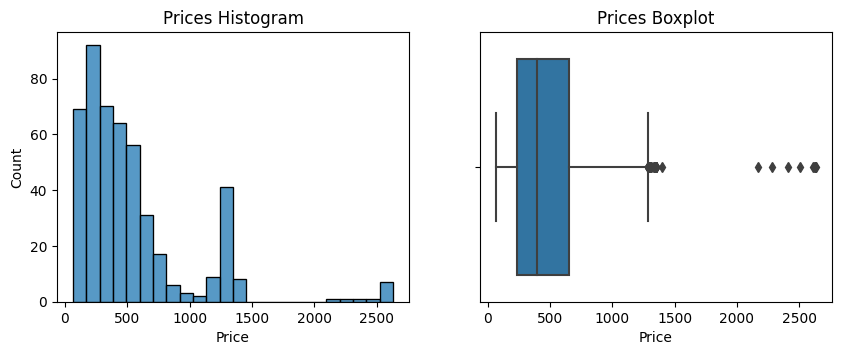

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3.5))
sns.histplot(data=df_cleaned, x="Price", ax=ax1).set(title='Prices Histogram')
sns.boxplot(x=df_cleaned["Price"], ax=ax2).set(title='Prices Boxplot')
plt.savefig('Price_Distribution.png')

Based on price distribution, we can note that:
- Most of Price falls around 200-700 dollars range, with median around 300 dollars
- There are 2 several notable outliers which are around 1200 dollars and approximately 2500 dollars

                             Values  Count
0                         Lufthansa    156
1                           Finnair     83
2                           Ryanair     41
3                               SAS     35
4                           Ryanair     28
5                               KLM     22
6                           easyJet     21
8                 Austrian Airlines     18
7                         airBaltic     18
9                   British Airways     16
10                Brussels Airlines     16
11                        Norwegian     14
12            Scandinavian Airlines     14
13                       Air France     12
14                       Air Europa     12
15                          Vueling     11
16                        Norwegian     11
18                Multiple airlines     10
17                            Swiss     10
19                  British Airways      9
20                         Wizz Air      8
21                           Iberia      7
22         

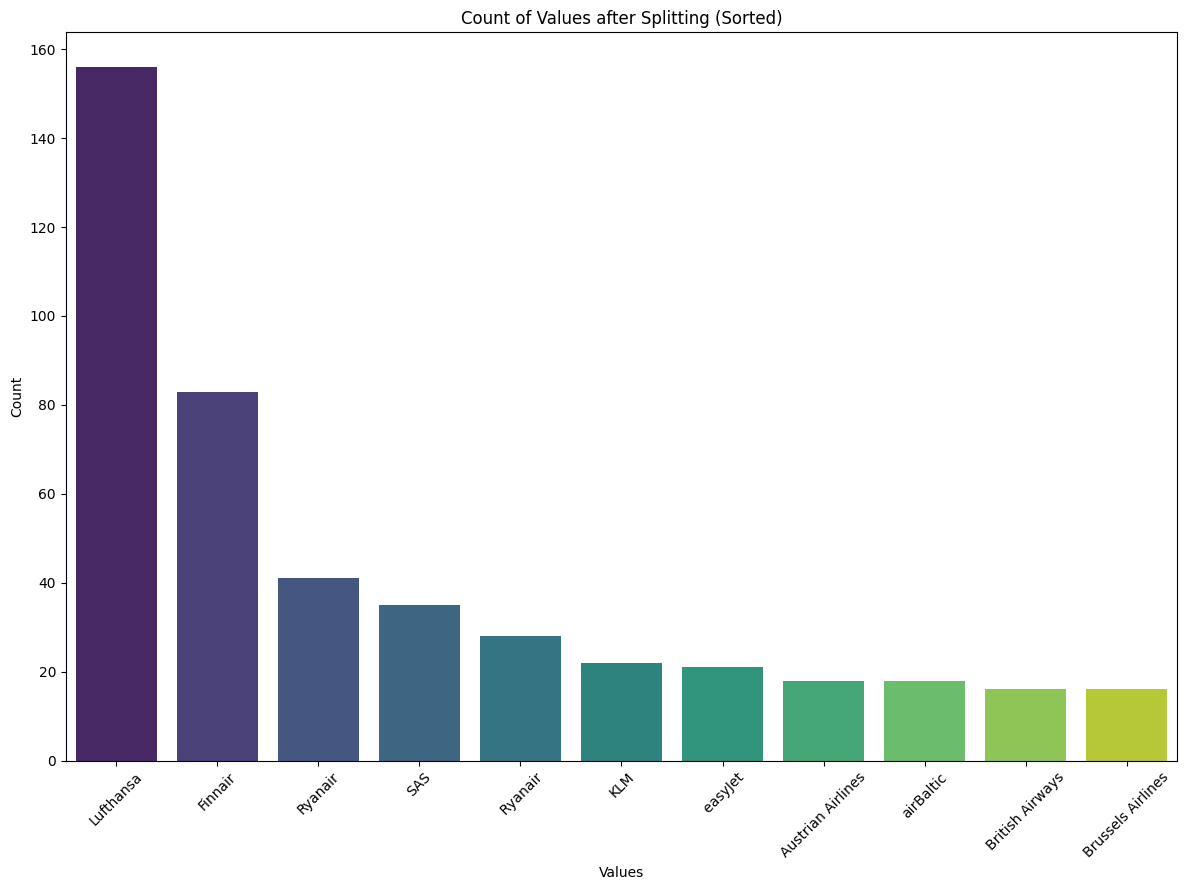

In [ ]:
# Create a DataFrame
filter_airline = pd.DataFrame()

# Split the column values by comma and explode
filter_airline['Airlines'] = df_cleaned['Airline'].str.split(',')
filter_airline = filter_airline.explode('Airlines')

airline_counts = filter_airline['Airlines'].value_counts().reset_index()
airline_counts.columns = ['Values', 'Count']
airline_counts = airline_counts.sort_values(by='Count', ascending=False)

print(airline_counts)

# Create a bar plot with count aggregation in a sorted way
plt.figure(figsize=(12, 9))
sns.barplot(x='Values', y='Count', data=airline_counts[:11], palette='viridis')
plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Count of Values after Splitting (Sorted)')
plt.xticks(rotation=45)

plt.savefig('Airline_Count.png')
# Show the plot
plt.tight_layout()
plt.show()

Based on airline count distribution, we can note that:
- Lufthansa has the most data (around 160 datapoints) that is nearly twice of the second airline which is Finnair (approximately 80 datapoints). It is make sense since based on the Wikipedia, it stands as the second-largest airline in Europe in terms of passengers carried, after the ultra low-cost carrier Ryanair.
- On the other hand, Finnair would also be favorite because of this flight is from Helsinki, Finland and most of the people would prefer Finnair, compared to the other.
- The other top 9 data besides Lufthansa and Finnair aren't that significant, with maximum 41 and minimum 15 flights


   Values  Count
0     FRA    156
1     MUC     98
2     CPH     67
3     MAD     51
4     ARN     43
5     ZRH     38
6     AMS     36
7     BCN     29
8     BRU     23
9     STN     22
10    LHR     22
11    VIE     19
13    RIX     18
12    OSL     18
14    CDG     13
15    WAW     11
16    DUS     10
17    LGW      9
18    STR      9
19      -      8


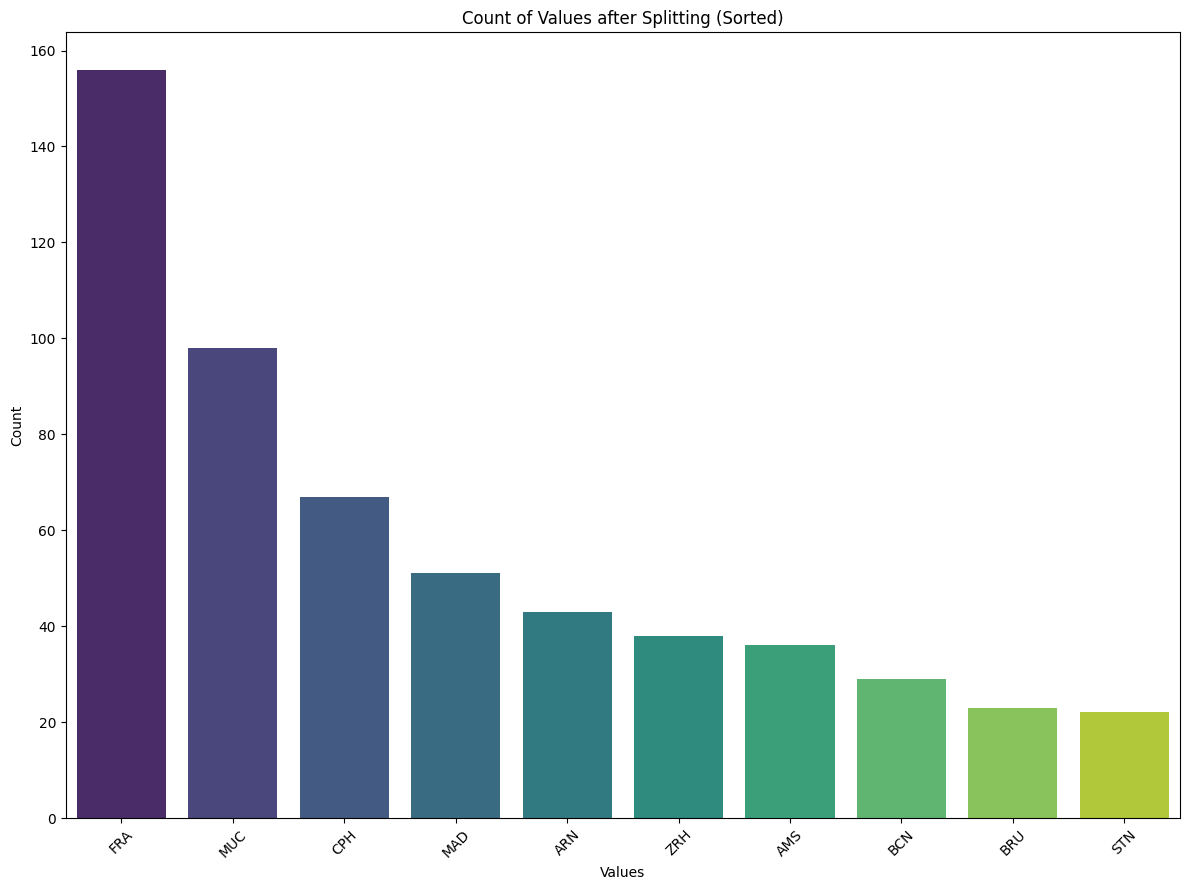

In [ ]:
# Create a DataFrame
temp = pd.DataFrame()

# Split the column values by comma and explode
temp['Place_Code'] = df_cleaned['Layover Place Code'].str.split(',')
temp = temp.explode('Place_Code')

value_counts = temp['Place_Code'].value_counts().reset_index()
value_counts.columns = ['Values', 'Count']
value_counts = value_counts.sort_values(by='Count', ascending=False)

print(value_counts[:20])

# Create a bar plot with count aggregation in a sorted way
plt.figure(figsize=(12, 9))
sns.barplot(x='Values', y='Count', data=value_counts[:10], palette='viridis')
plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Count of Values after Splitting (Sorted)')
plt.xticks(rotation=45)
plt.savefig('LayoverPlace_Count.png')

# Show the plot
plt.tight_layout()
plt.show()

Based on layover places count distribution, we can note that:
- France (FRA) is the most favorite place to layover (around 140 datapoints) that is nearly twice of the second place which is Munich (MUC datapoints) (approximately 80) and followed by Copenhagen (CPH) at the third place with (roughly 60 datapoints)
- The top 4 is very reasonable to be at the top. France, Munich, and Copenhagen airport are all in the Southwest part of Finland and one of the shortest ways to travel to Spain. The fourth one which is Madrid the capital city of Spain, it would be reasonable to have it in the top contender as layover places.
- The other top 9 data besides Lufthansa and Finnair aren't that significant, with maximum 41 and minimum 15 flights.

In [ ]:
def plot_average_histogram_sorted(df, col):
  # Calculate the average of column A for each unique value in column B
  average_price = df.groupby(col)['Price'].mean()
  # Sort the results in descending order
  average_price = average_price.sort_values(ascending=False)
  print()
  print(average_price)
  print(df[col].value_counts())
  # Plot the average values
  average_price.plot(kind='bar')
  if col == "No. Transit":
    col = "No. Layover"
  plt.xlabel(col)
  plt.xticks(rotation=45)
  plt.ylabel('Average of Price')
  plt.title('Average of Price by ' + col + ' Value')
  plt.savefig('Average of Price by ' + col + ' Value.png', bbox_inches='tight')
  plt.show()


No. Transit
2 stops    667.273599
1 stop     348.721667
3 stops    336.500000
Direct     193.627500
Name: Price, dtype: float64
2 stops    289
1 stop     180
Direct       8
3 stops      2
Name: No. Transit, dtype: int64


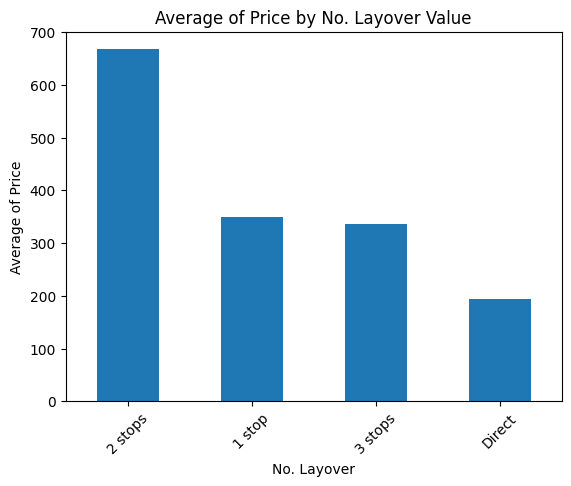

In [ ]:
plot_average_histogram_sorted(df_cleaned, 'No. Transit')

Based on No.Transit Average Aggregation, we can note that:
- The average price of "2 stops" cost the most expensive around 660 Dollars.

- Followed by the average price of "3 Stops" and "1 Stop" respectively with small difference, even though there are "2 stops" difference between them.

- The average price of "Direct" cost the cheapest which is logically True, since the least flight compared to others.

- Note that flights with "2 stops" have more data than each other, for imbalanced data, it is more than one and half times more expensive compared to flights with "1 stop". Moreover, after reducing the number is still one half of the flights with "1 stop".

- On other hand "Direct" flights with have less than 10 data, around 7 data, while  flights "3 stops" have only 2 data



Website
Booking    863.523026
Momondo    357.516779
Kayak      267.977778
Name: Price, dtype: float64
Booking    195
Momondo    149
Kayak      135
Name: Website, dtype: int64


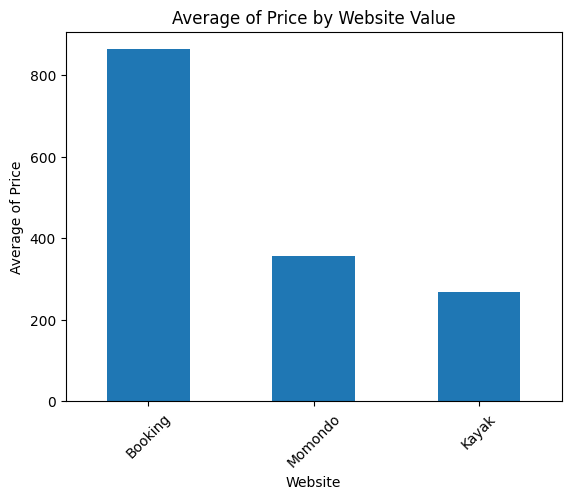

In [ ]:
plot_average_histogram_sorted(df_cleaned, 'Website')

Based on Website Average Aggregation, we can note that:
- The average price of Booking cost the most expensive, which is around one and half times more expensive the average price of Kayak.

- The average price of Kayak is always the cheapest with the comparison around 14 dollars compared to Momondo, the second cheapest



Group_25% Layover
3    660.435833
2    541.951667
1    540.589917
4    409.047899
Name: Price, dtype: float64
1    120
2    120
3    120
4    119
Name: Group_25% Layover, dtype: int64


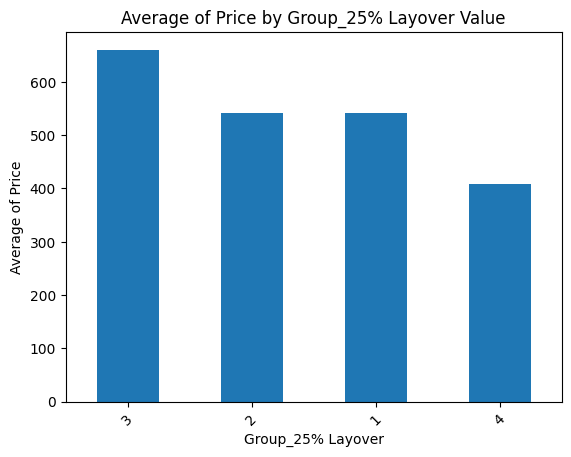

In [ ]:
plot_average_histogram_sorted(new_df_equal_sort_layover, 'Group_25% Layover')

The Group is distributed uniformly such that all the group will have the same amount of data (25% of the data).
For each group description:
- Group 1 : 0 days 00:00:00 - 0 days 03:35:00
- Group 2 : 0 days 03:40:00 - 0 days 06:30:00
- Group 3 : 0 days 06:40:00 - 0 days 10:00:00
- Group 4 : More than 0 days 10:00:00

Based on Layover Group Average Aggregation, we can note that:
- The average price of Group 3 are the most expensive, which could be explained since most of the flights are having "2 stops" before arriving at Palma Mallorca.

- Followed by group 1 and 2 at the same level, since the difference is 1 dollars which is less significant. It is good to note that since this calculation for layover time, and we have more data with "1 stop" then, the duration from group 1 is mostly affected by it compared to the "Direct" flight.

- Last but not least, Group 4 is the cheapest with average price around 400 dollars. The difference between Group 4 and Group 1,2 are in equal level compared to The difference between Group 3 (The Most Expensive) and Group 1,2. This one is also reasonable. Since the waiting time is extremely long (More than 10 hours, The maximum from my data for the uniform distributed data around 41 hours). In my opinion, the lower price is the compensation for the waiting time.


Group_25% Duration
3    590.938583
2    573.402583
1    532.258667
4    455.815210
Name: Price, dtype: float64
1    120
2    120
3    120
4    119
Name: Group_25% Duration, dtype: int64


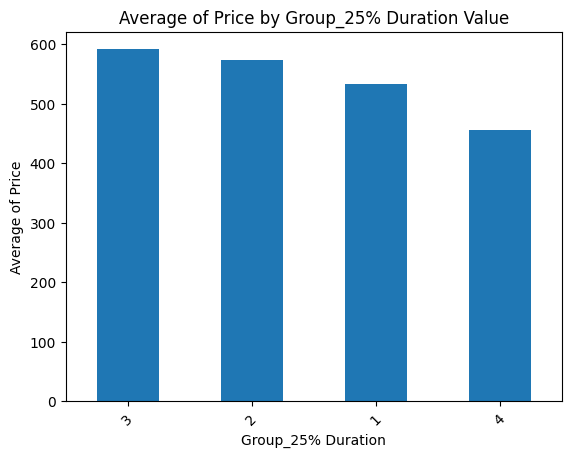

In [ ]:
plot_average_histogram_sorted(new_df_equal_sort_duration, 'Group_25% Duration')

The Group is distributed uniformly such that all the group will have the same amount of data (25% of the data).
For each group description:
- Group 1 : 0 days 00:00:00 - 0 days 09:20:00
- Group 2 : 0 days 09:20:00 - 0 days 12:30:00
- Group 3 : 0 days 12:30:00 - 0 days 15:55:00
- Group 4 : Equal/More than 0 days 16:00:00

In general the analysis is the same with layover time, because most of the duration is the summation from the layover time with the travel time

In [ ]:
def check_departure(df):
  # Morning time is typically considered to be the hours between 6am and noon.
  # Afternoon is typically considered to be the hours between noon and 6pm,
  # Evening is typically considered to be the hours between 6pm and midnight, and
  # Night is typically considered to be the hours between midnight and 6am.

  date_string = '2023-10-28'
  morning = "06:00:00"
  noon = "12:00:00"
  evening = "18:00:00"
  night_1 = "23:59:59"
  night_2 = "00:00:00"


  # Combine date and time strings

  departure = datetime.strptime(df["Departure"], '%Y-%m-%d %H:%M:%S')

  morning_datetime = date_string + ' ' + morning
  morning_time = datetime.strptime(morning_datetime, '%Y-%m-%d %H:%M:%S')

  noon_datetime = date_string + ' ' + noon
  noon_time = datetime.strptime(noon_datetime, '%Y-%m-%d %H:%M:%S')

  evening_datetime = date_string + ' ' + evening
  evening_time = datetime.strptime(evening_datetime, '%Y-%m-%d %H:%M:%S')

  night_1_datetime = date_string + ' ' + night_1
  night_1_time = datetime.strptime(night_1_datetime, '%Y-%m-%d %H:%M:%S')

  night_2_datetime = date_string + ' ' + night_2
  night_2_time = datetime.strptime(night_2_datetime, '%Y-%m-%d %H:%M:%S')

  # Check the range
  if morning_time <= departure and departure < noon_time :
    return "morning"
  elif noon_time <= departure and departure < evening_time :
    return "noon"
  elif evening_time <= departure and departure < night_1_time :
    return "evening"
  elif night_2_time <= departure and departure < morning_time :
    return "night"
  else:
    print(departure)
    print("Error")

def normalize_datetime_booking(df):
  df["Departure Status"] = df.apply(lambda x: check_departure(x), axis = 1)

normalize_datetime_booking(df_cleaned)

In [ ]:
df_cleaned

,Airline,Departure,Arrival,No. Transit,Layover Place Code,Layover Place,Layover Time,Duration,Website,Price,Departure Status
0,Norwegian Air International Ltd,2023-10-28 06:00:00,2023-10-28 09:00:00,Direct,-,-,0 days 00:00:00,0 days 04:00:00,Booking,110.54,morning
1,SAS,2023-10-28 07:00:00,2023-10-28 13:15:00,1 stop,CPH,CPH,0 days 02:35:00,0 days 07:15:00,Booking,130.88,morning
2,Ryanair,2023-10-28 22:50:00,2023-10-29 10:25:00,1 stop,"STN,LTN","STN,LTN",0 days 07:15:00,0 days 12:35:00,Booking,119.24,evening
3,Norwegian Air International Ltd,2023-10-28 06:15:00,2023-10-28 18:35:00,1 stop,CPH,CPH,0 days 02:35:00,0 days 13:20:00,Booking,127.70,morning
4,Ryanair,2023-10-28 22:50:00,2023-10-29 11:15:00,1 stop,"STN,LGW","STN,LGW",0 days 08:10:00,0 days 13:25:00,Booking,135.90,evening
...,...,...,...,...,...,...,...,...,...,...,...
474,Brussels Airlines,2023-10-28 06:40:00,2023-10-28 17:10:00,2 stops,"FRA,BRU","Frankfurt am Main, Brussels Bruxelles-National",0 days 05:50:00,0 days 11:30:00,Momondo,718.00,morning
475,Scandinavian Airlines,2023-10-28 07:00:00,2023-10-28 20:40:00,2 stops,"CPH,GOT","Kastrup Copenhagen, Gothenburg Landvetter",0 days 08:55:00,0 days 14:40:00,Momondo,684.00,morning
476,Scandinavian Airlines,2023-10-28 07:00:00,2023-10-28 20:40:00,2 stops,"CPH,GOT","Kastrup Copenhagen, Gothenburg Landvetter",0 days 09:00:00,0 days 14:40:00,Momondo,684.00,morning
477,Scandinavian Airlines,2023-10-28 07:00:00,2023-10-28 19:25:00,2 stops,"CPH,OSL","Kastrup Copenhagen, Oslo Gardermoen",0 days 07:00:00,0 days 13:25:00,Momondo,740.00,morning



Departure Status
morning    657.654418
noon       410.811837
evening    301.057867
night      211.428571
Name: Price, dtype: float64
morning    292
noon        98
evening     75
night       14
Name: Departure Status, dtype: int64


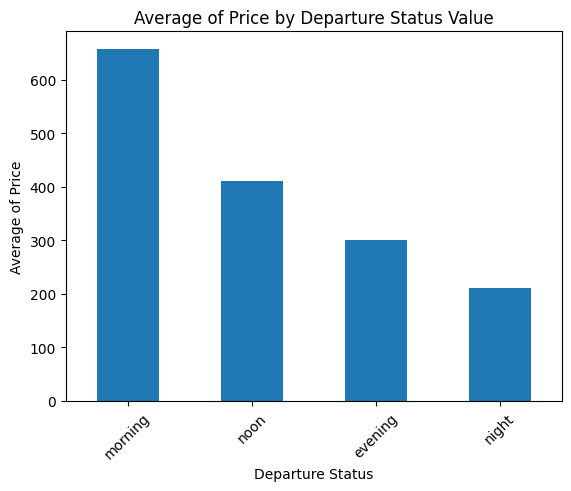

In [ ]:
plot_average_histogram_sorted(df_cleaned, 'Departure Status')

Based on Departure Status Average Aggregation, we can note that:
- The average price of morning cost the most expensive around 650 Dollars which is greater than the sum of the average price of Evening(300) and Night(200) which is around 500 dollars. It is reasonable because the morning time is the best to do the travel, since you can arrive at Palma at least at the same day around Noon/Evening. It is also more convenient to travel in the morning because most of people are working on the morning, then they are used to do get up early rather than stay up late night to wait for the flight, especially for the Family and Friend that usually deliver the one.

- Followed by the Noon at the average price 400 dollars, with large difference approximately 250 dollars.

- The last two categories are quite cheap, flight at Evening at around 300 dollars and flight at Night at around 200 dollars, which both have difference 100 and 200 dollars respectively to the Noon flight (half of the difference between morning and noon). It is also reasonable, because most of the people and their family wouldn't be convenient to go to airport at the night and would preferably choose the evening instead. It is also because usually airport is far way from the city, and it is inconvenient to go far away in the middle of night.

# User Interface

In [ ]:
pip install ipywidgets

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

In [ ]:
df_cleaned = pd.read_csv("all_cleaned.csv")
df_cleaned

,Airline,Departure,Arrival,No. Transit,Layover Place Code,Layover Place,Layover Time,Duration,Website,Price
0,Norwegian Air International Ltd,2023-10-28 06:00:00,2023-10-28 09:00:00,Direct,-,-,0 days 00:00:00,0 days 04:00:00,Booking,110.54
1,SAS,2023-10-28 07:00:00,2023-10-28 13:15:00,1 stop,CPH,CPH,0 days 02:35:00,0 days 07:15:00,Booking,130.88
2,Ryanair,2023-10-28 22:50:00,2023-10-29 10:25:00,1 stop,"STN,LTN","STN,LTN",0 days 07:15:00,0 days 12:35:00,Booking,119.24
3,Norwegian Air International Ltd,2023-10-28 06:15:00,2023-10-28 18:35:00,1 stop,CPH,CPH,0 days 02:35:00,0 days 13:20:00,Booking,127.70
4,Ryanair,2023-10-28 22:50:00,2023-10-29 11:15:00,1 stop,"STN,LGW","STN,LGW",0 days 08:10:00,0 days 13:25:00,Booking,135.90
...,...,...,...,...,...,...,...,...,...,...
474,Brussels Airlines,2023-10-28 06:40:00,2023-10-28 17:10:00,2 stops,"FRA,BRU","Frankfurt am Main, Brussels Bruxelles-National",0 days 05:50:00,0 days 11:30:00,Momondo,718.00
475,Scandinavian Airlines,2023-10-28 07:00:00,2023-10-28 20:40:00,2 stops,"CPH,GOT","Kastrup Copenhagen, Gothenburg Landvetter",0 days 08:55:00,0 days 14:40:00,Momondo,684.00
476,Scandinavian Airlines,2023-10-28 07:00:00,2023-10-28 20:40:00,2 stops,"CPH,GOT","Kastrup Copenhagen, Gothenburg Landvetter",0 days 09:00:00,0 days 14:40:00,Momondo,684.00
477,Scandinavian Airlines,2023-10-28 07:00:00,2023-10-28 19:25:00,2 stops,"CPH,OSL","Kastrup Copenhagen, Oslo Gardermoen",0 days 07:00:00,0 days 13:25:00,Momondo,740.00


In [ ]:
airline_uniqueness = df_cleaned["Airline"].unique()
sorted_airline_uniqueness = sorted(airline_uniqueness)
prices_maxi = df_cleaned["Price"].max()
prices_mini = df_cleaned["Price"].min()
prices_median = (prices_maxi+prices_mini)//2

In [ ]:
# Create widgets for hours and minutes
max_layover_hours = widgets.IntSlider(value=0, min=0, max=23, description='Hours:')
max_layover_minutes = widgets.IntSlider(value=0, min=0, max=59, description='Minutes:')

# Function to display selected time
def display_max_layover_time(hours, minutes):
    selected_time = f"{hours:02d}:{minutes:02d}:00"
    print(f"Selected maximum layover time: {selected_time}")

# Create an interactive output widget to display the selected time
output_max_layover = widgets.interactive_output(display_max_layover_time, {'hours': max_layover_hours, 'minutes': max_layover_minutes})

# Create a VBox layout to arrange widgets vertically
max_layover_widget = widgets.VBox([max_layover_hours, max_layover_minutes, output_max_layover])

In [ ]:
# Create widgets for hours and minutes
max_duration_hours = widgets.IntSlider(value=0, min=0, max=23, description='Hours:')
max_duration_minutes = widgets.IntSlider(value=0, min=0, max=59, description='Minutes:')

# Function to display selected time
def display_max_duration_time(hours, minutes):
    selected_time = f"{hours:02d}:{minutes:02d}:00"
    print(f"Selected maximum duration time: {selected_time}")

# Create an interactive output widget to display the selected time
output_max_duration = widgets.interactive_output(display_max_duration_time, {'hours': max_duration_hours, 'minutes': max_duration_minutes})

# Create a VBox layout to arrange widgets vertically
max_duration_widget = widgets.VBox([max_duration_hours, max_duration_minutes, output_max_duration])

In [ ]:
# Define the options for the single-choice selection
options = ['Direct', '1 stop', '2 stops', '3 stops']

# Create a RadioButtons widget
stop_option = widgets.RadioButtons(
    options=options,
    description='Select one option:',
)

# Create a VBox to hold the single-choice widget
stop_vbox = widgets.VBox([stop_option])

In [ ]:
prices_range = widgets.IntRangeSlider(
    value=[prices_mini, prices_maxi],
    min=prices_mini,
    max=prices_maxi,
    step=1,
    description='Price Range:',
)

In [ ]:
# Define the labels for the checkboxes
airlines_checkbox_labels = sorted_airline_uniqueness

# Create Checkbox widgets for each option
airlines_checkboxes = [widgets.Checkbox(value=False, description=label) for label in airlines_checkbox_labels]

# Define the number of columns in the grid
num_columns = 3

# Create a grid layout for the checkboxes
airlines_vbox = widgets.GridBox(airlines_checkboxes, layout=widgets.Layout(grid_template_columns=f"repeat({num_columns}, 1fr)"))

In [ ]:
time_sorter = widgets.ToggleButtons(
            options=['Ascending', 'Descending']
        )

price_sorter = widgets.ToggleButtons(
            options=['Ascending', 'Descending']
        )

In [ ]:
# button process
button_process = widgets.Button(
                description='Process',
                tooltip='Send',
                style={'description_width': 'initial'}
            )

output = widgets.Output()

def on_button_clicked(event):
    with output:
        clear_output()
        print_all_result()

button_process.on_click(on_button_clicked)

vbox_process = widgets.VBox([button_process, output])

# button clear
button_clear = widgets.Button(
                description='Clear',
                tooltip='Send',
                style={'description_width': 'initial'}
            )

output = widgets.Output()

def on_button_clicked(event):
    with output:
        clear_output()

button_clear.on_click(on_button_clicked)

vbox_clear = widgets.VBox([button_clear, output])

In [ ]:
def process(prices_min, prices_max, price_sorter, max_duration_hours, max_duration_minutes, stop_option, max_layover_hours, max_layover_minutes, time_sorter, airlines_checkboxes):
  duration_time = max_duration_hours*60 + max_duration_minutes
  layover_time = max_layover_hours*60 + max_layover_minutes
  print()
  if layover_time > duration_time:
    duration_time = f"{max_duration_hours:02d}:{max_duration_minutes:02d}:00"
    layover_time = f"{max_layover_hours:02d}:{max_layover_minutes:02d}:00"
    print(f"Selected maximum duration time: {duration_time}")
    print(f"Selected maximum layover time: {layover_time}")
    print("I think Maximum Duration Should Be Greater Than Maximum Layover. I think you should change it")
  elif prices_min > prices_max:
    print(f"Selected minimum prices: {prices_min}")
    print(f"Selected maximum prices: {prices_max}")
    print("I think Maximum Prices Should Be Greater Than Minimum Prices. I think you should change it")
  else:
    # Filter Price
    df_filtered = df_cleaned[(df_cleaned["Price"]<=prices_max) & (df_cleaned["Price"]>=prices_min)]
    print("After Filtering Price: ", len(df_filtered))
    # Filter Time
    df_filtered['Duration'] = pd.to_timedelta(df_filtered['Duration'])
    df_filtered['Layover Time'] = pd.to_timedelta(df_filtered['Layover Time'])
    duration_time = timedelta(hours=int(max_duration_hours), minutes=int(max_duration_minutes))
    layover_time = timedelta(hours=int(max_layover_hours), minutes=int(max_layover_minutes))
    df_filtered = df_filtered[df_filtered["Duration"]<=duration_time]
    print("After Filtering Duration: ", len(df_filtered))
    # Filter No. Stop
    df_filtered = df_filtered[df_filtered["No. Transit"] == stop_option]
    print("After Filtering No.Stop: ", len(df_filtered))
    if "stop" in stop_option:
      df_filtered = df_filtered[df_filtered["Layover Time"]<=layover_time]
    print("After Filtering Layover Time: ", len(df_filtered))
    # Filter Airline
    count = 0
    list_airlines = []
    df_filtered_airlines = pd.DataFrame()
    for data in airlines_checkboxes:
      if data.value:
        count += 1
        df_temp = df_filtered[df_filtered["Airline"]==data.description]
        df_filtered_airlines = df_filtered_airlines.append(df_temp, ignore_index=True)
    if count == 0:
      df_filtered_airlines = df_filtered
    print("After Filtering Layover Time: ", len(df_filtered_airlines))
    # Sort by Duration
    df_sorted_duration = df_filtered_airlines.sort_values(["Duration"], ascending = time_sorter)
    # Sort by Price
    df_sorted_price = df_sorted_duration.sort_values(["Price"], ascending = price_sorter)
    if len(df_filtered_airlines)==0 :
      print("Sorry \U0001F972, We didn't have enough data, but at least we can provide you Non-Filtered data")
    return df_sorted_price
  return None

In [ ]:
def print_all_result():
  if price_sorter.value == "Ascending" :
    ascending_price = True
  else:
    ascending_price = False
  if time_sorter.value == "Ascending" :
    ascending_time = True
  else:
    ascending_time = False
  result_df = process(prices_range.value[0], prices_range.value[1], ascending_price, max_duration_hours.value, max_duration_minutes.value, stop_option.value, max_layover_hours.value, max_layover_minutes.value, ascending_time, airlines_checkboxes)
  print()
  display(result_df)

In [ ]:
text_0 = widgets.HTML(value="<h1>Dear Customer \U0001F603, Choose Your Flight Package !!! </h1>")
note_0 = widgets.HTML(value="<h3>Note: You can input the data instead of sliding it </h3>")
text_1 = widgets.HTML(value="<h2>Prices </h2>")
text_2 = widgets.HTML(value="<h2>How do you want to sort the price ?</h2>")
text_3 = widgets.HTML(value="<h2>Maximum Durations</h2>")
text_4 = widgets.HTML(value="<h2>Direct or Layover?</h2>")
text_5 = widgets.HTML(value="<h4>Direct flight layover time would be ignored</h4>")
text_6 = widgets.HTML(value="<h2>Maximum Layovers</h2>")
text_6_0 = widgets.HTML(value="<h2>How do you want to sort the duration ?</h2>")
text_7 = widgets.HTML(value="<h2>Pick your preferable airlines</h2>")
text_7_0 = widgets.HTML(value="<h4>If you didn't choose, then it will show all of them without filtering</h4>")
text_8 = widgets.HTML(value="<h2>We will sort your Flights only, with this order Durations, and then Prices \U0001F604</h2>")
text_8_0 = widgets.HTML(value="<h4>We won't use Layover as the sorting since it would be similar to Duration, but still we will use it for the filtering \U0001F609</h4>")
text_9 = widgets.HTML(value="<h2>Show me the results</h2>")
text_10 = widgets.HTML(value="<h2>Clear the current results</h2>")

vbox_text = widgets.VBox([text_0, note_0, text_1, prices_range, text_2, price_sorter, text_3, max_duration_widget, text_4, stop_vbox, text_5, text_6, max_layover_widget, text_6_0, time_sorter, text_7, text_7_0, airlines_vbox,  text_8, text_8_0, text_9, vbox_process, text_10, vbox_clear])

In [ ]:
page = widgets.HBox([vbox_text])
display(page)

In [ ]:
# Create widgets for hours and minutes
departure_hours = widgets.IntSlider(value=0, min=0, max=23, description='Hours:')
departure_minutes = widgets.IntSlider(value=0, min=0, max=59, description='Minutes:')

# Function to display selected time
def display_departure_time(hours, minutes):
    selected_time = f"{hours:02d}:{minutes:02d}:00"
    print(f"Selected maximum duration time: {selected_time}")

# Create an interactive output widget to display the selected time
output_departure = widgets.interactive_output(display_departure_time, {'hours': departure_hours, 'minutes': departure_minutes})

# Create a VBox layout to arrange widgets vertically
departure_widget = widgets.VBox([departure_hours, departure_minutes, output_departure])

In [ ]:
# Create widgets for hours and minutes
max_duration_hours_1 = widgets.IntSlider(value=0, min=0, max=23, description='Hours:')
max_duration_minutes_1 = widgets.IntSlider(value=0, min=0, max=59, description='Minutes:')

# Function to display selected time
def display_max_duration_time_1(hours, minutes):
    selected_time = f"{hours:02d}:{minutes:02d}:00"
    print(f"Selected maximum duration time: {selected_time}")

# Create an interactive output widget to display the selected time
output_max_duration_1 = widgets.interactive_output(display_max_duration_time_1, {'hours': max_duration_hours_1, 'minutes': max_duration_minutes_1})

# Create a VBox layout to arrange widgets vertically
max_duration_widget_1 = widgets.VBox([max_duration_hours_1, max_duration_minutes_1, output_max_duration_1])

In [ ]:
# Define the labels for the checkboxes
airlines_checkbox_labels = sorted_airline_uniqueness

# Create Checkbox widgets for each option
airlines_checkboxes_1 = [widgets.Checkbox(value=False, description=label) for label in airlines_checkbox_labels]

# Define the number of columns in the grid
num_columns = 3

# Create a grid layout for the checkboxes
airlines_vbox_1 = widgets.GridBox(airlines_checkboxes_1, layout=widgets.Layout(grid_template_columns=f"repeat({num_columns}, 1fr)"))

In [ ]:
def process_cheapest_fastest(departure_hours, departure_minutes, max_duration_hours_1, max_duration_minutes_1, airlines_checkboxes_1):
  # Filter Departure
  # Combine date and time strings
  date_string = '2023-10-28'
  time_string = str(departure_hours)+":"+str(departure_minutes)+":00"
  datetime_string = date_string + ' ' + time_string
  # Convert to datetime using pd.to_datetime
  datetime_24hr = datetime.strptime(datetime_string, '%Y-%m-%d %H:%M:%S')
  df_cleaned['Departure'] = pd.to_datetime(df_cleaned['Departure'])
  df_filtered = df_cleaned[df_cleaned["Departure"]>=datetime_24hr]
  print()
  print("After Filtering Departure: ", len(df_filtered))

  # Filter Duration
  df_filtered['Duration'] = pd.to_timedelta(df_filtered['Duration'])
  duration_time = timedelta(hours=int(max_duration_hours_1), minutes=int(max_duration_minutes_1))
  df_filtered = df_filtered[df_filtered["Duration"]<=duration_time]
  print("After Filtering Duration: ", len(df_filtered))

  # Filter Airline
  count = 0
  list_airlines = []
  df_filtered_airlines = pd.DataFrame()
  for data in airlines_checkboxes_1:
    if data.value:
      count += 1
      df_temp = df_filtered[df_filtered["Airline"]==data.description]
      df_filtered_airlines = df_filtered_airlines.append(df_temp, ignore_index=True)
  if count == 0:
    df_filtered_airlines = df_filtered
  print("After Filtering Airline: ", len(df_filtered_airlines))

  # Sort by Duration, If Duration is the same show the cheapest
  df_sorted_duration = df_filtered_airlines.sort_values(["Duration", "Price"], ascending = True)
  # Sort by Price
  df_sorted_price = df_filtered_airlines.sort_values(["Price"], ascending = True)

  if len(df_filtered_airlines)==0 :
    print("Sorry \U0001F972, We didn't have enough data, but at least we can provide you Non-Filtered data")
  return df_sorted_price, df_sorted_duration


In [ ]:
def print_result_cheapest_fastest():
  cheapest_df, fastest_df = process_cheapest_fastest(departure_hours.value, departure_minutes.value, max_duration_hours_1.value, max_duration_minutes_1.value, airlines_checkboxes_1)
  print()
  print("Cheapest Flight:")
  display(cheapest_df[:1])
  print()
  print("Fastest Flight:")
  display(fastest_df[:1])

In [ ]:
# button process
button_process_1 = widgets.Button(
                description='Process',
                tooltip='Send',
                style={'description_width': 'initial'}
            )

output_1 = widgets.Output()

def on_button_clicked(event):
    with output_1:
        clear_output()
        print_result_cheapest_fastest()

button_process_1.on_click(on_button_clicked)

vbox_process_1 = widgets.VBox([button_process_1, output_1])

# button clear
button_clear_1 = widgets.Button(
                description='Clear',
                tooltip='Send',
                style={'description_width': 'initial'}
            )

output_1 = widgets.Output()

def on_button_clicked(event):
    with output_1:
        clear_output()

button_clear_1.on_click(on_button_clicked)

vbox_clear_1 = widgets.VBox([button_clear_1, output_1])

In [ ]:
text_0 = widgets.HTML(value="<h1>Dear Customer \U0001F603, Choose Your Priority !!! </h1>")
note_0 = widgets.HTML(value="<h3>We will show the Fastest and the Cheapest </h3>")
text_1 = widgets.HTML(value="<h2>Earliest Convenient Time of Departure </h2>")
text_2 = widgets.HTML(value="<h2>Maximum Travel Time </h2>")
text_3 = widgets.HTML(value="<h2>Pick your preferable airlines</h2>")
text_4 = widgets.HTML(value="<h4>If you didn't choose, then it will show all of them without filtering</h4>")
text_9 = widgets.HTML(value="<h2>Show me the results</h2>")
text_10 = widgets.HTML(value="<h2>Clear the current results</h2>")

vbox_text_1 = widgets.VBox([text_0, note_0, text_1, departure_widget, text_2, max_duration_widget_1, text_3, text_4, airlines_vbox_1, text_9, vbox_process_1, text_10, vbox_clear_1])

In [ ]:
page_1 = widgets.HBox([vbox_text_1])
display(page_1)